In [1]:
import os
import numpy as np
import tensorflow as tf
#import data as d
#import model
import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader import data,wb
import matplotlib.pyplot as plt

In [4]:
pip install pandas_datareader

     |████████████████████████████████| 107 kB 612 kB/s eta 0:00:01
     |████████████████████████████████| 5.5 MB 4.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
class StockData():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            indexPath : 종목시장의 인덱스 주 csv파일의 경로.
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈. 10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,indexPath,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize):        
               
        if(train_test_rate<=0 or train_test_rate>=1):
            raise ValueError('train_test_rate should be between 0 and 1')        
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath      
        self.indexPath=indexPath    
        self.batchSize=batchSize
        self.date_duration=3000
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))

        self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}
    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option is not 'training' and option is not 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')

        if(option is 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])             
        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,10,self.T,1))
        xn=np.reshape(xn,(-1,10,self.T,1))
        xi=np.reshape(xi,(-1,self.T,1))
        target=np.reshape(target,(-1,1))

        print("data1 : " , y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize],
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize],
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize],
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize],
                   'target':target[i*self.batchSize:(i+1)*self.batchSize]}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)        
        dataframe = pd.DataFrame([])
        

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python')
            if(len(data)>self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data['open']

                dataframe=dataframe.append(data,ignore_index=True)
        dataT=np.array(dataframe).T
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataT=dataT.T
        dataframe=pd.DataFrame(dataT)
        dataframe=dataframe.transpose()
        print('StockPrice shape: ',dataframe.shape)
        return dataframe
    
    def loadIndex(self):
        data=pd.read_csv(self.indexPath,engine='python')
        data=data[-self.date_duration-1:-1]        
        data=data.reset_index()
        data=data.fillna(method='ffill')

        data=np.array(data['Open'])
        data=np.reshape(data,(-1,1))

        data=self.indexScaler.fit_transform(data)

        data=pd.DataFrame(np.squeeze(data))        

        print('IndexPrice shape: ',data.shape)
        return data 


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in range(maxday,len(self.stockPrice)):
            print('making dataset progress : {}/{}'.format(i,len(self.stockPrice)),end='\r')
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexPrice.loc[i-self.T:i-1]

            for targetNum in priceSet.columns:
                target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[targetNum].T),(10,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[targetNum].T),(10,self.T,1))
                index_history=np.reshape(np.array(indexSet),(self.T,1))
                target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                            })
        print('making dataset progress : finished\t')
        
        return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            posSet.columns=range(self.P)
            negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

            
"""testLine
kospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)
print(np.shape(kospi.trainSet))
print(np.shape(kospi.testSet))
"""


"testLine\nkospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)\nprint(np.shape(kospi.trainSet))\nprint(np.shape(kospi.testSet))\n"

In [3]:

rnn=tf.compat.v1.nn.rnn_cell
class base_LSTMCell(rnn.BasicLSTMCell):
    def __call__(self,inputs,state,scope=None):
        """Long short-term memory cell (LSTM)."""
        with tf.variable_scope(scope or type(self).__name__):  # "BasicLSTMCell"
        # Parameters of gates are concatenated into one multiply for efficiency.
            if self._state_is_tuple:
                c, h = state
            else:
                c, h = tf.split(1, 2, state)
            concat = tf.layers.dense(tf.concat([inputs, h],axis=1), 4 * self._num_units)

            # i = input_gate, j = new_input, f = forget_gate, o = output_gate
            i, j, f, o = tf.split(concat, 4, 1)

            new_c = (c * tf.sigmoid(f + self._forget_bias) + tf.sigmoid(i) *
                    self._activation(j))
            new_h = self._activation(new_c) * tf.sigmoid(o)

            if self._state_is_tuple:
                new_state = rnn.LSTMStateTuple(new_c, new_h)
            else:
                new_state = tf.concat(1, [new_c, new_h])
        return new_h, new_state

class MI_LSTMCell(rnn.BasicLSTMCell):
    """
    Multi-Input LSTM proposed in the paper, Stock Price Prediction Using Attention-based Multi-Input LSTM.
    """
    def __init__(self,
               num_units,
               num_inputs,
               forget_bias=1.0,
               state_is_tuple=True,
               activation=None,
               reuse=None,
               name=None,
               dtype=None,
               **kwargs):
        """
        Initialize the basic LSTM cell.
        args:
            num_inputs: MI-LSTM의 입력의 개수. 
                이 파라미터에 따라 입력 게이트의 어텐션 레이어를 설정.
                최소 1개이상.
                1개일 경우, 어텐션 레이어를 제외하고 기본 LSTM과 동일.
        """        
        super(MI_LSTMCell,self).__init__(num_units,
               forget_bias=1.0,
               state_is_tuple=True,
               activation=None,
               reuse=None,
               name=None,
               dtype=None,
               **kwargs)
        
        if(type(num_inputs) is not int):
            raise ValueError("num_inputs should be integer")
        if(num_inputs < 1):
            raise ValueError("num_inputs should not be less than 0")
        self.num_inputs = num_inputs
        self.alpha_weight=self.add_variable('alpha_weight',shape=[self._num_units,self._num_units])
        self.alpha_bias=[]
        for i in range(self.num_inputs):
            self.alpha_bias.append(self.add_variable('alpha_bias'+str(i),shape=[1],initializer=tf.zeros_initializer()))

    def __call__(self,inputs,state,scope=None):
        """Long short-term memory cell (LSTM)."""
        with tf.compat.v1.variable_scope(scope or type(self).__name__):  # "BasicLSTMCell"
        # Parameters of gates are concatenated into one multiply for efficiency.
            if self._state_is_tuple:
                c, h = state
            else:
                c, h = tf.split(1, 2, state)
            inputs_list = tf.split(inputs,self.num_inputs,1)
            concat = tf.compat.v1.layers.dense(tf.concat([inputs_list[0], h],axis=1), (3+self.num_inputs) * self._num_units)
                                 
            # 0 = forget_gate, 1 = output_gate, 2= main_new_input, 3 = main_input_gate, 4~ = input_gate_for_auxiliary
            main_list = tf.split(concat, 3+self.num_inputs, 1)
                        
            #new_input_gate= list of all new_input.
            new_input_gate=[tf.tanh(main_list[2])]
            #linear layer for auxiliary inputs.
            for i in range(1,self.num_inputs):
                new_input_gate.append(tf.compat.v1.layers.dense(tf.concat([inputs_list[i], h],axis=1),self._num_units,activation=tf.tanh))

            #making list of l. l = sigmoid(input_gate) * tanh(new_input)
            new_l=[]
            for i,new_input in enumerate(new_input_gate,3):
                new_l.append(tf.sigmoid(main_list[i]) * new_input)


            #making list of u.            
            u=[]
            for i,l in enumerate(new_l):
                #temp = transpos(l) X W X Cell_State.
                temp1=tf.matmul(l,self.alpha_weight)
                temp1=tf.expand_dims(temp1,1)
                temp2=tf.matmul(temp1,tf.expand_dims(c,2))
                u.append(tf.tanh(tf.squeeze(temp2+self.alpha_bias[i],axis=2)))

            #making list of alpha.
            alpha=tf.nn.softmax(u,axis=0)

            #making L.
            L=[]
            for i,l in enumerate(new_l):
                L.append(alpha[i]*l)
            L=tf.reduce_sum(L,axis=0)


            #new state = c(t-1) * f + L. new h = tanh(c) + sigmoid(o)
            new_c = (c * tf.sigmoid(main_list[0] + self._forget_bias)+L)
            new_h = self._activation(new_c) * tf.sigmoid(main_list[1])

            if self._state_is_tuple:
                new_state = rnn.LSTMStateTuple(new_c, new_h)
            else:
                new_state = tf.concat(1, [new_c, new_h])
        return new_h, new_state


class Attention_Layer():
    """
    어텐션 레이어.
    (None, TimeWindow, hidden_unit_size) shape의 LSTM 출력을 입력으로 받아 (None, 1, hidden_unit_size)의 텐서 출력.
    
    """
    def __init__(
        self,
        timewindow_size,
        input_hidden_unit_size,
        attention_size=None):
        """
        Setting parameter for attention layer.
        args:
            timewindow_size = time window size of previous lstm layer.
            input_hidden_unit_size = hidden unit number of previous lstm layer.
            attention_size = size of this attention. 
                default = input_hidden_unit_size.
        """
        if(attention_size is None):
            attention_size=input_hidden_unit_size
        self.o_size=attention_size
        self.h_size=input_hidden_unit_size
        self.t_size=timewindow_size

        self.beta_weight=tf.Variable(tf.random.normal([self.h_size,self.o_size]), name='beta_weight')
        self.beta_bias=tf.Variable(tf.zeros([self.o_size]),name='beta_bias')

        self.v=tf.Variable(tf.random.normal([self.o_size,1]),name='beta_v')

    def __call__(self,inputs):
        """
        producing output with actual inputs.
        shape of output will be (batch_size, 1, input_hidden_unit_size).
        """
        #temp = tanh(Y X W + b) ->shape of result = (-1, self.o_size)
        temp=tf.matmul(tf.reshape(inputs,[-1,self.h_size]),self.beta_weight)
         
        temp=tf.tanh(temp+self.beta_bias)
        
            
        #j=temp X v
        j=tf.reshape(tf.matmul(temp,self.v),[-1,self.t_size,1])

        beta=tf.nn.softmax(j)
        
        

        output=beta*inputs
        return output



In [4]:
class Model():
    """
    모든 예측모델들의 기본 클래스
    """
    def __init__(self,sess,name,windowsize,Pos,Neg):
        self.sess=sess
        self.name=name
        self.T=windowsize
        self.P=Pos
        self.N=Neg

        
        self._build_net()

    def _build_net(self):
        pass

class LSTM_Model(Model):
    """
    Basic LSTM list for test.
    """
    def _build_net(self):
        self.Y=tf.compat.v1.placeholder(tf.float32,[None,self.T,1])
        self.Xp=tf.compat.v1.placeholder(tf.float32,[None,self.P,self.T,1])
        self.Xn=tf.compat.v1.placeholder(tf.float32,[None,self.N,self.T,1])
        self.Xi=tf.compat.v1.placeholder(tf.float32,[None,self.T,1])
        self.Target=tf.compat.v1.placeholder(tf.float32,[None,1])


        Xps=tf.split(self.Xp,self.P,1)
        Xns=tf.split(self.Xn,self.N,1)
        Xp_list=[]
        Xn_list=[]

    
        LSTM=tf.compat.v1.nn.rnn_cell.LSTMCell(64,name='lstm1')
        
        Y_1,_=tf.compat.v1.nn.dynamic_rnn(LSTM,self.Y,dtype=tf.float32)
        Xi_1,_=tf.compat.v1.nn.dynamic_rnn(LSTM,self.Xi,dtype=tf.float32)
        for i in range(len(Xps)):
            o,_=tf.compat.v1.nn.dynamic_rnn(LSTM,tf.squeeze(Xps[i],axis=1),dtype=tf.float32)
            Xp_list.append(o)
        for i in range(len(Xns)):
            o,_=tf.compat.v1.nn.dynamic_rnn(LSTM,tf.squeeze(Xns[i],axis=1),dtype=tf.float32)
            Xn_list.append(o)
        Xp_1=tf.reduce_mean(Xp_list,0)
        Xn_1=tf.reduce_mean(Xn_list,0)

        result=tf.concat([Y_1,Xp_1,Xn_1,Xi_1],axis=2)
       

        #MI-LSTM
        LSTM2=MI_LSTMCell(64,4,name='lstm2')
       
        Y_2,_ =tf.compat.v1.nn.dynamic_rnn(LSTM2,result,dtype=tf.float32)
       

        #Attention_Layer
        attention_layer=Attention_Layer(self.T,64)
        
        Y_3=attention_layer(Y_2)
        

        #Non-linear units for producing final prediction.
        R_1=tf.compat.v1.layers.dense(tf.compat.v1.layers.flatten(Y_3),64,tf.nn.relu)
        
        R_2=tf.compat.v1.layers.dense(R_1,64,tf.nn.relu)
        
        R_3=tf.compat.v1.layers.dense(R_2,64,tf.nn.relu)
        
        R_4=tf.compat.v1.layers.dense(R_3,64,tf.nn.relu)
        
        R_5=tf.compat.v1.layers.dense(R_4,64,tf.nn.relu)
        
        R_6=tf.compat.v1.layers.dense(R_5,1)
       
        self.out=R_6
        
        self.cost=tf.compat.v1.losses.mean_squared_error(labels=self.Target,predictions=self.out)
        self.optimizer=tf.compat.v1.train.AdamOptimizer(0.001).minimize(self.cost)

    def outputs(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run(self.out,feed_dict=fd)

    def training(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run([self.cost,self.optimizer],feed_dict=fd)

    def returnCost(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run(self.cost,feed_dict=fd)
        

## batch_size=512 & timesize_for_calc_correlation=50
## time_size=16 & positive_correlation_stock_num=10
## negative_correlation_sotck_num=10

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	

#training#
data1 :  (33040, 16, 1) (33040, 10, 16, 1) (33040, 10, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 10, 16, 1) (14160, 10, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  12.151818381622434
evalution_cost :  2.0907386243343353
epoch : 0, t_cost : 0.189872, e_cost : 0.077435, elapsed time : 21.00sec
data1 :  (33040, 16, 1) (33040, 10, 16, 1) (33040, 10, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 10, 16, 1) (14160, 10, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  4.562195286620408
evalution_cost :  1.1595759186893702
epoch : 1, t_cost : 0.071284, e_cost : 0.042947, elapsed time : 15.82sec
data1 :  (33040, 16, 1) (33040, 10, 16, 1) (33040, 10, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 10, 16, 1) (14160, 10, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  2.5645700064487755
evalution_cost :  0.8752674646675587
epoc

data1 :  (14160, 16, 1) (14160, 10, 16, 1) (14160, 10, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.7116842726245522
evalution_cost :  0.271144853788428
epoch : 25, t_cost : 0.011120, e_cost : 0.010042, elapsed time : 15.81sec
data1 :  (33040, 16, 1) (33040, 10, 16, 1) (33040, 10, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 10, 16, 1) (14160, 10, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.7379376032622531
evalution_cost :  0.27058058488182724
epoch : 26, t_cost : 0.011530, e_cost : 0.010022, elapsed time : 15.78sec
data1 :  (33040, 16, 1) (33040, 10, 16, 1) (33040, 10, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 10, 16, 1) (14160, 10, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.7092851148918271
evalution_cost :  0.27239211183041334
epoch : 27, t_cost : 0.011083, e_cost : 0.010089, elapsed time : 15.78sec
data1 :  (33040, 16, 1) (33040, 10, 16, 1) (33040, 10, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 1

data1 :  (14160, 16, 1) (14160, 10, 16, 1) (14160, 10, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.6593101194011979
evalution_cost :  0.27059119613841176
epoch : 51, t_cost : 0.010302, e_cost : 0.010022, elapsed time : 15.62sec
data1 :  (33040, 16, 1) (33040, 10, 16, 1) (33040, 10, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 10, 16, 1) (14160, 10, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.6504580090986565
evalution_cost :  0.27474858693312854
epoch : 52, t_cost : 0.010163, e_cost : 0.010176, elapsed time : 15.65sec
data1 :  (33040, 16, 1) (33040, 10, 16, 1) (33040, 10, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 10, 16, 1) (14160, 10, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.6453325267066248
evalution_cost :  0.2691866582026705
epoch : 53, t_cost : 0.010083, e_cost : 0.009970, elapsed time : 15.65sec
data1 :  (33040, 16, 1) (33040, 10, 16, 1) (33040, 10, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 

data1 :  (14160, 16, 1) (14160, 10, 16, 1) (14160, 10, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.6061778370640241
evalution_cost :  0.2877485966309905
epoch : 77, t_cost : 0.009472, e_cost : 0.010657, elapsed time : 15.89sec
data1 :  (33040, 16, 1) (33040, 10, 16, 1) (33040, 10, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 10, 16, 1) (14160, 10, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.6052636710810475
evalution_cost :  0.2864697743207216
epoch : 78, t_cost : 0.009457, e_cost : 0.010610, elapsed time : 16.03sec
data1 :  (33040, 16, 1) (33040, 10, 16, 1) (33040, 10, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 10, 16, 1) (14160, 10, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.5752643407322466
evalution_cost :  0.2745484139304608
epoch : 79, t_cost : 0.008989, e_cost : 0.010168, elapsed time : 15.85sec
data1 :  (33040, 16, 1) (33040, 10, 16, 1) (33040, 10, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 10

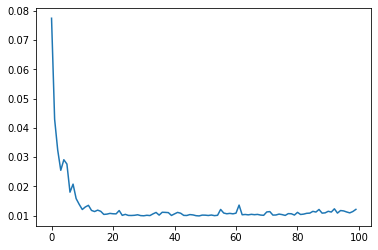

In [11]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'data/temporal/sample',
    'data/temporal/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

## batch_size=512 & timesize_for_calc_correlation=50
## time_size=32 & positive_correlation_stock_num=10
## negative_correlation_sotck_num=10

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	

#training#
data1 :  (33040, 32, 1) (33040, 10, 32, 1) (33040, 10, 32, 1) (33040, 32, 1) (33040, 1)
data1 :  (14160, 32, 1) (14160, 10, 32, 1) (14160, 10, 32, 1) (14160, 32, 1) (14160, 1)
traning_cost :  16.12831725552678
evalution_cost :  2.9044743701815605
epoch : 0, t_cost : 0.252005, e_cost : 0.107573, elapsed time : 39.00sec
data1 :  (33040, 32, 1) (33040, 10, 32, 1) (33040, 10, 32, 1) (33040, 32, 1) (33040, 1)
data1 :  (14160, 32, 1) (14160, 10, 32, 1) (14160, 10, 32, 1) (14160, 32, 1) (14160, 1)
traning_cost :  5.1374327428638935
evalution_cost :  1.9121726267039776
epoch : 1, t_cost : 0.080272, e_cost : 0.070821, elapsed time : 32.25sec
data1 :  (33040, 32, 1) (33040, 10, 32, 1) (33040, 10, 32, 1) (33040, 32, 1) (33040, 1)
data1 :  (14160, 32, 1) (14160, 10, 32, 1) (14160, 10, 32, 1) (14160, 32, 1) (14160, 1)
traning_cost :  2.8671424235217273
evalution_cost :  1.0756272561848164
epoc

data1 :  (14160, 32, 1) (14160, 10, 32, 1) (14160, 10, 32, 1) (14160, 32, 1) (14160, 1)
traning_cost :  0.6990303236525506
evalution_cost :  0.2795101081719622
epoch : 25, t_cost : 0.010922, e_cost : 0.010352, elapsed time : 31.48sec
data1 :  (33040, 32, 1) (33040, 10, 32, 1) (33040, 10, 32, 1) (33040, 32, 1) (33040, 1)
data1 :  (14160, 32, 1) (14160, 10, 32, 1) (14160, 10, 32, 1) (14160, 32, 1) (14160, 1)
traning_cost :  0.7151262152474374
evalution_cost :  0.27467595727648586
epoch : 26, t_cost : 0.011174, e_cost : 0.010173, elapsed time : 31.37sec
data1 :  (33040, 32, 1) (33040, 10, 32, 1) (33040, 10, 32, 1) (33040, 32, 1) (33040, 1)
data1 :  (14160, 32, 1) (14160, 10, 32, 1) (14160, 10, 32, 1) (14160, 32, 1) (14160, 1)
traning_cost :  0.7259600271354429
evalution_cost :  0.2771942017134279
epoch : 27, t_cost : 0.011343, e_cost : 0.010266, elapsed time : 31.41sec
data1 :  (33040, 32, 1) (33040, 10, 32, 1) (33040, 10, 32, 1) (33040, 32, 1) (33040, 1)
data1 :  (14160, 32, 1) (14160, 1

data1 :  (14160, 32, 1) (14160, 10, 32, 1) (14160, 10, 32, 1) (14160, 32, 1) (14160, 1)
traning_cost :  0.6586411480675451
evalution_cost :  0.3001873658504337
epoch : 51, t_cost : 0.010291, e_cost : 0.011118, elapsed time : 31.57sec
data1 :  (33040, 32, 1) (33040, 10, 32, 1) (33040, 10, 32, 1) (33040, 32, 1) (33040, 1)
data1 :  (14160, 32, 1) (14160, 10, 32, 1) (14160, 10, 32, 1) (14160, 32, 1) (14160, 1)
traning_cost :  0.651728812023066
evalution_cost :  0.2932052619289607
epoch : 52, t_cost : 0.010183, e_cost : 0.010859, elapsed time : 31.94sec
data1 :  (33040, 32, 1) (33040, 10, 32, 1) (33040, 10, 32, 1) (33040, 32, 1) (33040, 1)
data1 :  (14160, 32, 1) (14160, 10, 32, 1) (14160, 10, 32, 1) (14160, 32, 1) (14160, 1)
traning_cost :  0.6297414756845683
evalution_cost :  0.2838209271430969
epoch : 53, t_cost : 0.009840, e_cost : 0.010512, elapsed time : 31.38sec
data1 :  (33040, 32, 1) (33040, 10, 32, 1) (33040, 10, 32, 1) (33040, 32, 1) (33040, 1)
data1 :  (14160, 32, 1) (14160, 10,

data1 :  (14160, 32, 1) (14160, 10, 32, 1) (14160, 10, 32, 1) (14160, 32, 1) (14160, 1)
traning_cost :  0.5434133678209037
evalution_cost :  0.34046770399436355
epoch : 77, t_cost : 0.008491, e_cost : 0.012610, elapsed time : 31.38sec
data1 :  (33040, 32, 1) (33040, 10, 32, 1) (33040, 10, 32, 1) (33040, 32, 1) (33040, 1)
data1 :  (14160, 32, 1) (14160, 10, 32, 1) (14160, 10, 32, 1) (14160, 32, 1) (14160, 1)
traning_cost :  0.7044754261150956
evalution_cost :  0.33400807273574173
epoch : 78, t_cost : 0.011007, e_cost : 0.012371, elapsed time : 31.40sec
data1 :  (33040, 32, 1) (33040, 10, 32, 1) (33040, 10, 32, 1) (33040, 32, 1) (33040, 1)
data1 :  (14160, 32, 1) (14160, 10, 32, 1) (14160, 10, 32, 1) (14160, 32, 1) (14160, 1)
traning_cost :  0.5929797603166662
evalution_cost :  0.30000513861887157
epoch : 79, t_cost : 0.009265, e_cost : 0.011111, elapsed time : 31.45sec
data1 :  (33040, 32, 1) (33040, 10, 32, 1) (33040, 10, 32, 1) (33040, 32, 1) (33040, 1)
data1 :  (14160, 32, 1) (14160,

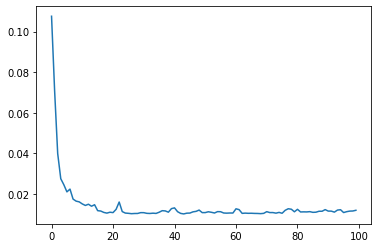

In [12]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=50
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'data/temporal/sample',
    'data/temporal/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

## batch_size=512 & timesize_for_calc_correlation=70
## time_size=16 & positive_correlation_stock_num=10
## negative_correlation_sotck_num=10

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	

#training#
data1 :  (32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  13.603649582713842
evalution_cost :  2.7839122489094734
epoch : 0, t_cost : 0.212557, e_cost : 0.103108, elapsed time : 21.34sec
data1 :  (32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  4.069283531978726
evalution_cost :  1.093699585646391
epoch : 1, t_cost : 0.063583, e_cost : 0.040507, elapsed time : 15.78sec
data1 :  (32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  2.599005624651909
evalution_cost :  0.8099827691912651
epoch 

data1 :  (14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.7704152343794703
evalution_cost :  0.2887101962696761
epoch : 25, t_cost : 0.012038, e_cost : 0.010693, elapsed time : 15.60sec
data1 :  (32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.7575040399096906
evalution_cost :  0.29333058826159686
epoch : 26, t_cost : 0.011836, e_cost : 0.010864, elapsed time : 15.59sec
data1 :  (32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.727268188726157
evalution_cost :  0.27958573237992823
epoch : 27, t_cost : 0.011364, e_cost : 0.010355, elapsed time : 15.61sec
data1 :  (32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 1

data1 :  (14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.6656573289074004
evalution_cost :  0.27726764883846045
epoch : 51, t_cost : 0.010401, e_cost : 0.010269, elapsed time : 15.72sec
data1 :  (32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.6573251888621598
evalution_cost :  0.27473151800222695
epoch : 52, t_cost : 0.010271, e_cost : 0.010175, elapsed time : 15.71sec
data1 :  (32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.6650690878741443
evalution_cost :  0.2870465904707089
epoch : 53, t_cost : 0.010392, e_cost : 0.010631, elapsed time : 15.71sec
data1 :  (32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 

data1 :  (14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.568152520339936
evalution_cost :  0.28060884308069944
epoch : 77, t_cost : 0.008877, e_cost : 0.010393, elapsed time : 15.80sec
data1 :  (32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.7006251658312976
evalution_cost :  0.3572938097640872
epoch : 78, t_cost : 0.010947, e_cost : 0.013233, elapsed time : 15.74sec
data1 :  (32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.6407189054880291
evalution_cost :  0.28922291728667915
epoch : 79, t_cost : 0.010011, e_cost : 0.010712, elapsed time : 15.77sec
data1 :  (32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 1

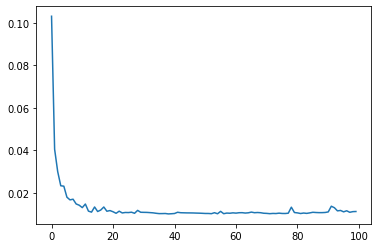

In [13]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=70
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'data/temporal/sample',
    'data/temporal/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

## batch_size=256 & timesize_for_calc_correlation=70
## time_size=16 & positive_correlation_stock_num=10
## negative_correlation_sotck_num=10

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	

#training#
data1 :  (32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  20.05883456300944
evalution_cost :  3.0724575147032738
epoch : 0, t_cost : 0.156710, e_cost : 0.056897, elapsed time : 22.07sec
data1 :  (32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  5.634061743854545
evalution_cost :  1.5425749458372593
epoch : 1, t_cost : 0.044016, e_cost : 0.028566, elapsed time : 16.57sec
data1 :  (32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  3.8942462779814377
evalution_cost :  1.38531637750566
epoch :

data1 :  (14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  1.4274798073456623
evalution_cost :  0.56781869858969
epoch : 25, t_cost : 0.011152, e_cost : 0.010515, elapsed time : 16.39sec
data1 :  (32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  1.345710045978194
evalution_cost :  0.589540937799029
epoch : 26, t_cost : 0.010513, e_cost : 0.010917, elapsed time : 16.33sec
data1 :  (32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  1.3372140442952514
evalution_cost :  0.593335137120448
epoch : 27, t_cost : 0.010447, e_cost : 0.010988, elapsed time : 16.40sec
data1 :  (32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 10, 16,

data1 :  (14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  1.221214840115863
evalution_cost :  0.6228292831219733
epoch : 51, t_cost : 0.009541, e_cost : 0.011534, elapsed time : 16.74sec
data1 :  (32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  1.1229751818464138
evalution_cost :  0.5872421665117145
epoch : 52, t_cost : 0.008773, e_cost : 0.010875, elapsed time : 16.85sec
data1 :  (32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  1.2372042042552494
evalution_cost :  0.656246546888724
epoch : 53, t_cost : 0.009666, e_cost : 0.012153, elapsed time : 16.52sec
data1 :  (32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 10, 

data1 :  (14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.7742735942301806
evalution_cost :  0.6579826719244011
epoch : 77, t_cost : 0.006049, e_cost : 0.012185, elapsed time : 16.50sec
data1 :  (32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.8140084420447238
evalution_cost :  0.6921000616857782
epoch : 78, t_cost : 0.006359, e_cost : 0.012817, elapsed time : 16.46sec
data1 :  (32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 10, 16, 1) (14064, 10, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.7929055238782894
evalution_cost :  0.6424818385858089
epoch : 79, t_cost : 0.006195, e_cost : 0.011898, elapsed time : 16.50sec
data1 :  (32816, 16, 1) (32816, 10, 16, 1) (32816, 10, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 10

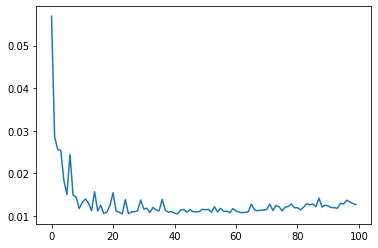

In [14]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=70
positive_correlation_stock_num=10
negative_correlation_sotck_num=10
train_test_rate=0.7
batch_size=256
#
kospi=StockData(
    'data/temporal/sample',
    'data/temporal/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

In [5]:
class StockData():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            indexPath : 종목시장의 인덱스 주 csv파일의 경로.
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈. 10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,indexPath,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize):        
               
        if(train_test_rate<=0 or train_test_rate>=1):
            raise ValueError('train_test_rate should be between 0 and 1')        
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath      
        self.indexPath=indexPath    
        self.batchSize=batchSize
        self.date_duration=3000
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))

        self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}
    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option is not 'training' and option is not 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')

        if(option is 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])             
        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,15,self.T,1))
        xn=np.reshape(xn,(-1,15,self.T,1))
        xi=np.reshape(xi,(-1,self.T,1))
        target=np.reshape(target,(-1,1))

        print("data1 : " , y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize],
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize],
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize],
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize],
                   'target':target[i*self.batchSize:(i+1)*self.batchSize]}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)        
        dataframe = pd.DataFrame([])
        

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python')
            if(len(data)>self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data['open']

                dataframe=dataframe.append(data,ignore_index=True)
        dataT=np.array(dataframe).T
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataT=dataT.T
        dataframe=pd.DataFrame(dataT)
        dataframe=dataframe.transpose()
        print('StockPrice shape: ',dataframe.shape)
        return dataframe
    
    def loadIndex(self):
        data=pd.read_csv(self.indexPath,engine='python')
        data=data[-self.date_duration-1:-1]        
        data=data.reset_index()
        data=data.fillna(method='ffill')

        data=np.array(data['Open'])
        data=np.reshape(data,(-1,1))

        data=self.indexScaler.fit_transform(data)

        data=pd.DataFrame(np.squeeze(data))        

        print('IndexPrice shape: ',data.shape)
        return data 


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in range(maxday,len(self.stockPrice)):
            print('making dataset progress : {}/{}'.format(i,len(self.stockPrice)),end='\r')
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexPrice.loc[i-self.T:i-1]

            for targetNum in priceSet.columns:
                target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[targetNum].T),(15,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[targetNum].T),(15,self.T,1))
                index_history=np.reshape(np.array(indexSet),(self.T,1))
                target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                            })
        print('making dataset progress : finished\t')
        
        return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            posSet.columns=range(self.P)
            negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

            
"""testLine
kospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)
print(np.shape(kospi.trainSet))
print(np.shape(kospi.testSet))
"""


"testLine\nkospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)\nprint(np.shape(kospi.trainSet))\nprint(np.shape(kospi.testSet))\n"

## batch_size=512 & timesize_for_calc_correlation=70
## time_size=16 & positive_correlation_stock_num=15
## negative_correlation_sotck_num=15

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	

#training#
data1 :  (32816, 16, 1) (32816, 15, 16, 1) (32816, 15, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 15, 16, 1) (14064, 15, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  14.251156464219093
evalution_cost :  3.225573878735304
epoch : 0, t_cost : 0.222674, e_cost : 0.119466, elapsed time : 29.47sec
data1 :  (32816, 16, 1) (32816, 15, 16, 1) (32816, 15, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 15, 16, 1) (14064, 15, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  4.724789183586836
evalution_cost :  1.146245600655675
epoch : 1, t_cost : 0.073825, e_cost : 0.042454, elapsed time : 21.18sec
data1 :  (32816, 16, 1) (32816, 15, 16, 1) (32816, 15, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 15, 16, 1) (14064, 15, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  2.6679481267929077
evalution_cost :  0.9396559167653322
epoch 

data1 :  (14064, 16, 1) (14064, 15, 16, 1) (14064, 15, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.7276132390834391
evalution_cost :  0.2745170061243698
epoch : 25, t_cost : 0.011369, e_cost : 0.010167, elapsed time : 21.22sec
data1 :  (32816, 16, 1) (32816, 15, 16, 1) (32816, 15, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 15, 16, 1) (14064, 15, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.7643689438700676
evalution_cost :  0.290804615826346
epoch : 26, t_cost : 0.011943, e_cost : 0.010771, elapsed time : 21.25sec
data1 :  (32816, 16, 1) (32816, 15, 16, 1) (32816, 15, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 15, 16, 1) (14064, 15, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.724756381008774
evalution_cost :  0.28142940904945135
epoch : 27, t_cost : 0.011324, e_cost : 0.010423, elapsed time : 21.44sec
data1 :  (32816, 16, 1) (32816, 15, 16, 1) (32816, 15, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 15,

data1 :  (14064, 16, 1) (14064, 15, 16, 1) (14064, 15, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.6914133497048169
evalution_cost :  0.2889921038877219
epoch : 51, t_cost : 0.010803, e_cost : 0.010703, elapsed time : 21.03sec
data1 :  (32816, 16, 1) (32816, 15, 16, 1) (32816, 15, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 15, 16, 1) (14064, 15, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.6962246431503445
evalution_cost :  0.27980256569571793
epoch : 52, t_cost : 0.010879, e_cost : 0.010363, elapsed time : 21.12sec
data1 :  (32816, 16, 1) (32816, 15, 16, 1) (32816, 15, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 15, 16, 1) (14064, 15, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.6922503104433417
evalution_cost :  0.2778474964434281
epoch : 53, t_cost : 0.010816, e_cost : 0.010291, elapsed time : 21.19sec
data1 :  (32816, 16, 1) (32816, 15, 16, 1) (32816, 15, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 1

data1 :  (14064, 16, 1) (14064, 15, 16, 1) (14064, 15, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.5964048407040536
evalution_cost :  0.287627155194059
epoch : 77, t_cost : 0.009319, e_cost : 0.010653, elapsed time : 21.16sec
data1 :  (32816, 16, 1) (32816, 15, 16, 1) (32816, 15, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 15, 16, 1) (14064, 15, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.5985507012810558
evalution_cost :  0.2936188414460048
epoch : 78, t_cost : 0.009352, e_cost : 0.010875, elapsed time : 21.14sec
data1 :  (32816, 16, 1) (32816, 15, 16, 1) (32816, 15, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 15, 16, 1) (14064, 15, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.6005430582445115
evalution_cost :  0.2946158153936267
epoch : 79, t_cost : 0.009383, e_cost : 0.010912, elapsed time : 21.19sec
data1 :  (32816, 16, 1) (32816, 15, 16, 1) (32816, 15, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 15,

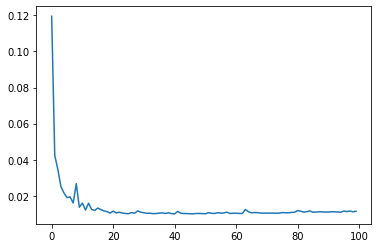

In [16]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'data/temporal/sample',
    'data/temporal/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

## batch_size=512 & timesize_for_calc_correlation=50
## time_size=16 & positive_correlation_stock_num=15
## negative_correlation_sotck_num=15

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	

#training#
data1 :  (33040, 16, 1) (33040, 15, 16, 1) (33040, 15, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 15, 16, 1) (14160, 15, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  12.996241556480527
evalution_cost :  2.9445632435381413
epoch : 0, t_cost : 0.203066, e_cost : 0.109058, elapsed time : 29.06sec
data1 :  (33040, 16, 1) (33040, 15, 16, 1) (33040, 15, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 15, 16, 1) (14160, 15, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  4.303227952681482
evalution_cost :  1.0538215655833483
epoch : 1, t_cost : 0.067238, e_cost : 0.039030, elapsed time : 21.16sec
data1 :  (33040, 16, 1) (33040, 15, 16, 1) (33040, 15, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 15, 16, 1) (14160, 15, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  2.2969746019225568
evalution_cost :  0.7520589120686054
epoc

data1 :  (14160, 16, 1) (14160, 15, 16, 1) (14160, 15, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.75285825796891
evalution_cost :  0.2866653478704393
epoch : 25, t_cost : 0.011763, e_cost : 0.010617, elapsed time : 21.18sec
data1 :  (33040, 16, 1) (33040, 15, 16, 1) (33040, 15, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 15, 16, 1) (14160, 15, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.7143484919797629
evalution_cost :  0.2744623307371512
epoch : 26, t_cost : 0.011162, e_cost : 0.010165, elapsed time : 21.17sec
data1 :  (33040, 16, 1) (33040, 15, 16, 1) (33040, 15, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 15, 16, 1) (14160, 15, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.7047763915034011
evalution_cost :  0.2876029417384416
epoch : 27, t_cost : 0.011012, e_cost : 0.010652, elapsed time : 21.14sec
data1 :  (33040, 16, 1) (33040, 15, 16, 1) (33040, 15, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 15, 

data1 :  (14160, 16, 1) (14160, 15, 16, 1) (14160, 15, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.6448271837434731
evalution_cost :  0.29206594661809504
epoch : 51, t_cost : 0.010075, e_cost : 0.010817, elapsed time : 21.26sec
data1 :  (33040, 16, 1) (33040, 15, 16, 1) (33040, 15, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 15, 16, 1) (14160, 15, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.6425163364619948
evalution_cost :  0.2956018862314522
epoch : 52, t_cost : 0.010039, e_cost : 0.010948, elapsed time : 21.15sec
data1 :  (33040, 16, 1) (33040, 15, 16, 1) (33040, 15, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 15, 16, 1) (14160, 15, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.6390912995557301
evalution_cost :  0.2836088731419295
epoch : 53, t_cost : 0.009986, e_cost : 0.010504, elapsed time : 21.12sec
data1 :  (33040, 16, 1) (33040, 15, 16, 1) (33040, 15, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 1

data1 :  (14160, 16, 1) (14160, 15, 16, 1) (14160, 15, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.5596558620454744
evalution_cost :  0.2798976660706103
epoch : 77, t_cost : 0.008745, e_cost : 0.010367, elapsed time : 21.24sec
data1 :  (33040, 16, 1) (33040, 15, 16, 1) (33040, 15, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 15, 16, 1) (14160, 15, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.5313599487999454
evalution_cost :  0.28027567942626774
epoch : 78, t_cost : 0.008302, e_cost : 0.010381, elapsed time : 21.15sec
data1 :  (33040, 16, 1) (33040, 15, 16, 1) (33040, 15, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 15, 16, 1) (14160, 15, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.5214750869199634
evalution_cost :  0.2933675996027887
epoch : 79, t_cost : 0.008148, e_cost : 0.010865, elapsed time : 21.23sec
data1 :  (33040, 16, 1) (33040, 15, 16, 1) (33040, 15, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 1

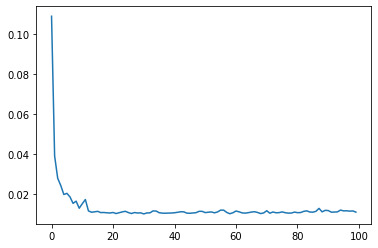

In [17]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'data/temporal/sample',
    'data/temporal/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

In [22]:
class StockData():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            indexPath : 종목시장의 인덱스 주 csv파일의 경로.
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈. 10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,indexPath,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize):        
               
        if(train_test_rate<=0 or train_test_rate>=1):
            raise ValueError('train_test_rate should be between 0 and 1')        
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath      
        self.indexPath=indexPath    
        self.batchSize=batchSize
        self.date_duration=3000
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))

        self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}
    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option is not 'training' and option is not 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')

        if(option is 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])             
        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,6,self.T,1))
        xn=np.reshape(xn,(-1,6,self.T,1))
        xi=np.reshape(xi,(-1,self.T,1))
        target=np.reshape(target,(-1,1))

        print("data1 : " , y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize],
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize],
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize],
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize],
                   'target':target[i*self.batchSize:(i+1)*self.batchSize]}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)        
        dataframe = pd.DataFrame([])
        

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python')
            if(len(data)>self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data['open']

                dataframe=dataframe.append(data,ignore_index=True)
        dataT=np.array(dataframe).T
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataT=dataT.T
        dataframe=pd.DataFrame(dataT)
        dataframe=dataframe.transpose()
        print('StockPrice shape: ',dataframe.shape)
        return dataframe
    
    def loadIndex(self):
        data=pd.read_csv(self.indexPath,engine='python')
        data=data[-self.date_duration-1:-1]        
        data=data.reset_index()
        data=data.fillna(method='ffill')

        data=np.array(data['Open'])
        data=np.reshape(data,(-1,1))

        data=self.indexScaler.fit_transform(data)

        data=pd.DataFrame(np.squeeze(data))        

        print('IndexPrice shape: ',data.shape)
        return data 


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in range(maxday,len(self.stockPrice)):
            print('making dataset progress : {}/{}'.format(i,len(self.stockPrice)),end='\r')
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexPrice.loc[i-self.T:i-1]

            for targetNum in priceSet.columns:
                target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[targetNum].T),(6,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[targetNum].T),(6,self.T,1))
                index_history=np.reshape(np.array(indexSet),(self.T,1))
                target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                            })
        print('making dataset progress : finished\t')
        
        return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            posSet.columns=range(self.P)
            negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

            
"""testLine
kospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)
print(np.shape(kospi.trainSet))
print(np.shape(kospi.testSet))
"""


"testLine\nkospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)\nprint(np.shape(kospi.trainSet))\nprint(np.shape(kospi.testSet))\n"

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	

#training#
data1 :  (33040, 16, 1) (33040, 6, 16, 1) (33040, 6, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 6, 16, 1) (14160, 6, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  12.137656182050705
evalution_cost :  2.298684500157833
epoch : 0, t_cost : 0.189651, e_cost : 0.085136, elapsed time : 15.51sec
data1 :  (33040, 16, 1) (33040, 6, 16, 1) (33040, 6, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 6, 16, 1) (14160, 6, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  4.013476986438036
evalution_cost :  1.1123241391032934
epoch : 1, t_cost : 0.062711, e_cost : 0.041197, elapsed time : 11.53sec
data1 :  (33040, 16, 1) (33040, 6, 16, 1) (33040, 6, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 6, 16, 1) (14160, 6, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  2.3318918829318136
evalution_cost :  0.8932482637465
epoch : 2, t_cost : 

traning_cost :  0.6818052197340876
evalution_cost :  0.27914721448905766
epoch : 25, t_cost : 0.010653, e_cost : 0.010339, elapsed time : 11.58sec
data1 :  (33040, 16, 1) (33040, 6, 16, 1) (33040, 6, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 6, 16, 1) (14160, 6, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.6468916524318047
evalution_cost :  0.273790062405169
epoch : 26, t_cost : 0.010108, e_cost : 0.010140, elapsed time : 11.57sec
data1 :  (33040, 16, 1) (33040, 6, 16, 1) (33040, 6, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 6, 16, 1) (14160, 6, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.6647855751798488
evalution_cost :  0.28216222976334393
epoch : 27, t_cost : 0.010387, e_cost : 0.010450, elapsed time : 11.56sec
data1 :  (33040, 16, 1) (33040, 6, 16, 1) (33040, 6, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 6, 16, 1) (14160, 6, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.6596166715607978
evalution_

traning_cost :  0.5888095444533974
evalution_cost :  0.2836743392981589
epoch : 51, t_cost : 0.009200, e_cost : 0.010506, elapsed time : 11.60sec
data1 :  (33040, 16, 1) (33040, 6, 16, 1) (33040, 6, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 6, 16, 1) (14160, 6, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.5775253914762288
evalution_cost :  0.3086915777530521
epoch : 52, t_cost : 0.009024, e_cost : 0.011433, elapsed time : 11.58sec
data1 :  (33040, 16, 1) (33040, 6, 16, 1) (33040, 6, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 6, 16, 1) (14160, 6, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.5583369351224974
evalution_cost :  0.3016722905449569
epoch : 53, t_cost : 0.008724, e_cost : 0.011173, elapsed time : 11.61sec
data1 :  (33040, 16, 1) (33040, 6, 16, 1) (33040, 6, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 6, 16, 1) (14160, 6, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.5507714379928075
evalution_c

data1 :  (14160, 16, 1) (14160, 6, 16, 1) (14160, 6, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.49124157772166654
evalution_cost :  0.32309910003095865
epoch : 77, t_cost : 0.007676, e_cost : 0.011967, elapsed time : 11.58sec
data1 :  (33040, 16, 1) (33040, 6, 16, 1) (33040, 6, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 6, 16, 1) (14160, 6, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.47865724517032504
evalution_cost :  0.3166168974712491
epoch : 78, t_cost : 0.007479, e_cost : 0.011727, elapsed time : 11.61sec
data1 :  (33040, 16, 1) (33040, 6, 16, 1) (33040, 6, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 6, 16, 1) (14160, 6, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.47968838771339506
evalution_cost :  0.31715235323645175
epoch : 79, t_cost : 0.007495, e_cost : 0.011746, elapsed time : 11.60sec
data1 :  (33040, 16, 1) (33040, 6, 16, 1) (33040, 6, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 6, 16, 1)

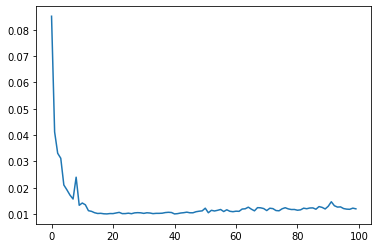

In [23]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=6
negative_correlation_sotck_num=6
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'data/temporal/sample',
    'data/temporal/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	

#training#
data1 :  (32816, 16, 1) (32816, 6, 16, 1) (32816, 6, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 6, 16, 1) (14064, 6, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  13.19416344165802
evalution_cost :  3.357640977948904
epoch : 0, t_cost : 0.206159, e_cost : 0.124357, elapsed time : 15.61sec
data1 :  (32816, 16, 1) (32816, 6, 16, 1) (32816, 6, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 6, 16, 1) (14064, 6, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  3.699443167075515
evalution_cost :  1.0197390671819448
epoch : 1, t_cost : 0.057804, e_cost : 0.037768, elapsed time : 11.59sec
data1 :  (32816, 16, 1) (32816, 6, 16, 1) (32816, 6, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 6, 16, 1) (14064, 6, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  2.517856564372778
evalution_cost :  0.9774186732247472
epoch : 2, t_cost :

traning_cost :  0.760658438783139
evalution_cost :  0.31382697611115873
epoch : 25, t_cost : 0.011885, e_cost : 0.011623, elapsed time : 11.58sec
data1 :  (32816, 16, 1) (32816, 6, 16, 1) (32816, 6, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 6, 16, 1) (14064, 6, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.7174647999927402
evalution_cost :  0.2900158643024042
epoch : 26, t_cost : 0.011210, e_cost : 0.010741, elapsed time : 11.58sec
data1 :  (32816, 16, 1) (32816, 6, 16, 1) (32816, 6, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 6, 16, 1) (14064, 6, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.6977738633286208
evalution_cost :  0.35538858314976096
epoch : 27, t_cost : 0.010903, e_cost : 0.013163, elapsed time : 11.64sec
data1 :  (32816, 16, 1) (32816, 6, 16, 1) (32816, 6, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 6, 16, 1) (14064, 6, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.8346212357282639
evalution_

traning_cost :  0.6700528610963374
evalution_cost :  0.28203823836520314
epoch : 51, t_cost : 0.010470, e_cost : 0.010446, elapsed time : 11.55sec
data1 :  (32816, 16, 1) (32816, 6, 16, 1) (32816, 6, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 6, 16, 1) (14064, 6, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.6732679202686995
evalution_cost :  0.28034949337597936
epoch : 52, t_cost : 0.010520, e_cost : 0.010383, elapsed time : 11.56sec
data1 :  (32816, 16, 1) (32816, 6, 16, 1) (32816, 6, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 6, 16, 1) (14064, 6, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.6609651730395854
evalution_cost :  0.2798926676623523
epoch : 53, t_cost : 0.010328, e_cost : 0.010366, elapsed time : 11.56sec
data1 :  (32816, 16, 1) (32816, 6, 16, 1) (32816, 6, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 6, 16, 1) (14064, 6, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.6488783666864038
evalution

traning_cost :  0.5341126346029341
evalution_cost :  0.29409037437289953
epoch : 77, t_cost : 0.008346, e_cost : 0.010892, elapsed time : 11.47sec
data1 :  (32816, 16, 1) (32816, 6, 16, 1) (32816, 6, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 6, 16, 1) (14064, 6, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.5634289660956711
evalution_cost :  0.2899019605247304
epoch : 78, t_cost : 0.008804, e_cost : 0.010737, elapsed time : 11.49sec
data1 :  (32816, 16, 1) (32816, 6, 16, 1) (32816, 6, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 6, 16, 1) (14064, 6, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.5418726436328143
evalution_cost :  0.29723385139368474
epoch : 79, t_cost : 0.008467, e_cost : 0.011009, elapsed time : 11.50sec
data1 :  (32816, 16, 1) (32816, 6, 16, 1) (32816, 6, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 6, 16, 1) (14064, 6, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.5253814951283857
evalution

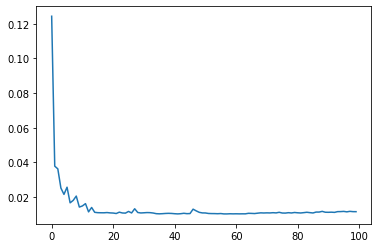

In [24]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=70
positive_correlation_stock_num=6
negative_correlation_sotck_num=6
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'data/temporal/sample',
    'data/temporal/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	

#training#
data1 :  (32816, 32, 1) (32816, 6, 32, 1) (32816, 6, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 6, 32, 1) (14064, 6, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  15.818374384194613
evalution_cost :  3.4149569422006607
epoch : 0, t_cost : 0.247162, e_cost : 0.126480, elapsed time : 26.84sec
data1 :  (32816, 32, 1) (32816, 6, 32, 1) (32816, 6, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 6, 32, 1) (14064, 6, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  6.42287926748395
evalution_cost :  1.5789646599441767
epoch : 1, t_cost : 0.100357, e_cost : 0.058480, elapsed time : 22.96sec
data1 :  (32816, 32, 1) (32816, 6, 32, 1) (32816, 6, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 6, 32, 1) (14064, 6, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  3.002096811309457
evalution_cost :  0.9899578783661127
epoch : 2, t_cost 

traning_cost :  0.8320857738144696
evalution_cost :  0.32422936568036675
epoch : 25, t_cost : 0.013001, e_cost : 0.012008, elapsed time : 22.88sec
data1 :  (32816, 32, 1) (32816, 6, 32, 1) (32816, 6, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 6, 32, 1) (14064, 6, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.7750269242096692
evalution_cost :  0.31090754456818104
epoch : 26, t_cost : 0.012110, e_cost : 0.011515, elapsed time : 22.92sec
data1 :  (32816, 32, 1) (32816, 6, 32, 1) (32816, 6, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 6, 32, 1) (14064, 6, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.7563804914243519
evalution_cost :  0.31002582237124443
epoch : 27, t_cost : 0.011818, e_cost : 0.011482, elapsed time : 22.89sec
data1 :  (32816, 32, 1) (32816, 6, 32, 1) (32816, 6, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 6, 32, 1) (14064, 6, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.7343410162720829
evalutio

traning_cost :  0.7212775354273617
evalution_cost :  0.3172602318227291
epoch : 51, t_cost : 0.011270, e_cost : 0.011750, elapsed time : 22.92sec
data1 :  (32816, 32, 1) (32816, 6, 32, 1) (32816, 6, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 6, 32, 1) (14064, 6, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.6686717171687633
evalution_cost :  0.3316844815853983
epoch : 52, t_cost : 0.010448, e_cost : 0.012285, elapsed time : 22.89sec
data1 :  (32816, 32, 1) (32816, 6, 32, 1) (32816, 6, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 6, 32, 1) (14064, 6, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.6423953457269818
evalution_cost :  0.28205960954073817
epoch : 53, t_cost : 0.010037, e_cost : 0.010447, elapsed time : 22.90sec
data1 :  (32816, 32, 1) (32816, 6, 32, 1) (32816, 6, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 6, 32, 1) (14064, 6, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.606971645494923
evalution_c

traning_cost :  0.47953883185982704
evalution_cost :  0.3803512759041041
epoch : 77, t_cost : 0.007493, e_cost : 0.014087, elapsed time : 22.87sec
data1 :  (32816, 32, 1) (32816, 6, 32, 1) (32816, 6, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 6, 32, 1) (14064, 6, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.4972319225780666
evalution_cost :  0.31485574459657073
epoch : 78, t_cost : 0.007769, e_cost : 0.011661, elapsed time : 22.88sec
data1 :  (32816, 32, 1) (32816, 6, 32, 1) (32816, 6, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 6, 32, 1) (14064, 6, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.47207116917707026
evalution_cost :  0.31289064756128937
epoch : 79, t_cost : 0.007376, e_cost : 0.011589, elapsed time : 22.88sec
data1 :  (32816, 32, 1) (32816, 6, 32, 1) (32816, 6, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 6, 32, 1) (14064, 6, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.47129984328057617
evalut

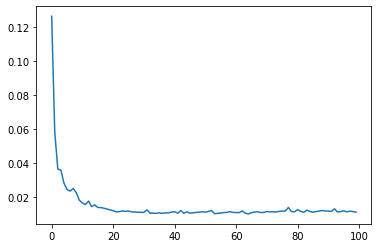

In [25]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=6
negative_correlation_sotck_num=6
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'data/temporal/sample',
    'data/temporal/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

In [26]:
class StockData():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            indexPath : 종목시장의 인덱스 주 csv파일의 경로.
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈. 10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,indexPath,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize):        
               
        if(train_test_rate<=0 or train_test_rate>=1):
            raise ValueError('train_test_rate should be between 0 and 1')        
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath      
        self.indexPath=indexPath    
        self.batchSize=batchSize
        self.date_duration=3000
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))

        self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}
    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option is not 'training' and option is not 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')

        if(option is 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])             
        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,4,self.T,1))
        xn=np.reshape(xn,(-1,4,self.T,1))
        xi=np.reshape(xi,(-1,self.T,1))
        target=np.reshape(target,(-1,1))

        print("data1 : " , y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize],
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize],
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize],
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize],
                   'target':target[i*self.batchSize:(i+1)*self.batchSize]}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)        
        dataframe = pd.DataFrame([])
        

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python')
            if(len(data)>self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data['open']

                dataframe=dataframe.append(data,ignore_index=True)
        dataT=np.array(dataframe).T
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataT=dataT.T
        dataframe=pd.DataFrame(dataT)
        dataframe=dataframe.transpose()
        print('StockPrice shape: ',dataframe.shape)
        return dataframe
    
    def loadIndex(self):
        data=pd.read_csv(self.indexPath,engine='python')
        data=data[-self.date_duration-1:-1]        
        data=data.reset_index()
        data=data.fillna(method='ffill')

        data=np.array(data['Open'])
        data=np.reshape(data,(-1,1))

        data=self.indexScaler.fit_transform(data)

        data=pd.DataFrame(np.squeeze(data))        

        print('IndexPrice shape: ',data.shape)
        return data 


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in range(maxday,len(self.stockPrice)):
            print('making dataset progress : {}/{}'.format(i,len(self.stockPrice)),end='\r')
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexPrice.loc[i-self.T:i-1]

            for targetNum in priceSet.columns:
                target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[targetNum].T),(4,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[targetNum].T),(4,self.T,1))
                index_history=np.reshape(np.array(indexSet),(self.T,1))
                target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                            })
        print('making dataset progress : finished\t')
        
        return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            posSet.columns=range(self.P)
            negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

            
"""testLine
kospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)
print(np.shape(kospi.trainSet))
print(np.shape(kospi.testSet))
"""


"testLine\nkospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)\nprint(np.shape(kospi.trainSet))\nprint(np.shape(kospi.testSet))\n"

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	

#training#
data1 :  (32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  13.13572870194912
evalution_cost :  2.666763871908188
epoch : 0, t_cost : 0.205246, e_cost : 0.098769, elapsed time : 22.25sec
data1 :  (32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  4.213794333860278
evalution_cost :  1.2504271566867828
epoch : 1, t_cost : 0.065841, e_cost : 0.046312, elapsed time : 18.68sec
data1 :  (32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  2.639022797346115
evalution_cost :  0.9390712017193437
epoch : 2, t_cost :

traning_cost :  0.7669043559581041
evalution_cost :  0.29154754942283034
epoch : 25, t_cost : 0.011983, e_cost : 0.010798, elapsed time : 18.89sec
data1 :  (32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.6912576237227768
evalution_cost :  0.29048260871786624
epoch : 26, t_cost : 0.010801, e_cost : 0.010759, elapsed time : 18.51sec
data1 :  (32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.6765385635662824
evalution_cost :  0.2842148676281795
epoch : 27, t_cost : 0.010571, e_cost : 0.010526, elapsed time : 18.39sec
data1 :  (32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.6651217124890536
evalution

traning_cost :  0.5685069165192544
evalution_cost :  0.28595866227988154
epoch : 51, t_cost : 0.008883, e_cost : 0.010591, elapsed time : 18.54sec
data1 :  (32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.5662740059196949
evalution_cost :  0.28733736323192716
epoch : 52, t_cost : 0.008848, e_cost : 0.010642, elapsed time : 18.46sec
data1 :  (32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.5479814796708524
evalution_cost :  0.27849627868272364
epoch : 53, t_cost : 0.008562, e_cost : 0.010315, elapsed time : 18.47sec
data1 :  (32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.6254266428295523
evalutio

data1 :  (14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.4628166820621118
evalution_cost :  0.31035494804382324
epoch : 77, t_cost : 0.007232, e_cost : 0.011495, elapsed time : 18.38sec
data1 :  (32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.46322121808771044
evalution_cost :  0.3061263468116522
epoch : 78, t_cost : 0.007238, e_cost : 0.011338, elapsed time : 18.45sec
data1 :  (32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.448756544617936
evalution_cost :  0.316223484929651
epoch : 79, t_cost : 0.007012, e_cost : 0.011712, elapsed time : 18.36sec
data1 :  (32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 4, 32, 1) (140

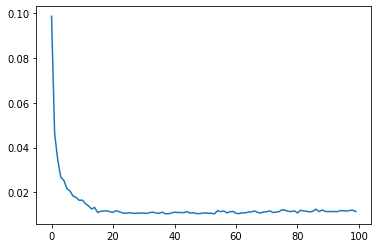

In [27]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=4
negative_correlation_sotck_num=4
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'data/temporal/sample',
    'data/temporal/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	

#training#
data1 :  (32479, 32, 1) (32479, 4, 32, 1) (32479, 4, 32, 1) (32479, 32, 1) (32479, 1)
data1 :  (13921, 32, 1) (13921, 4, 32, 1) (13921, 4, 32, 1) (13921, 32, 1) (13921, 1)
traning_cost :  13.509718239307404
evalution_cost :  3.101979549974203
epoch : 0, t_cost : 0.214440, e_cost : 0.114888, elapsed time : 21.21sec
data1 :  (32479, 32, 1) (32479, 4, 32, 1) (32479, 4, 32, 1) (32479, 32, 1) (32479, 1)
data1 :  (13921, 32, 1) (13921, 4, 32, 1) (13921, 4, 32, 1) (13921, 32, 1) (13921, 1)
traning_cost :  4.335070673376322
evalution_cost :  1.17442655749619
epoch : 1, t_cost : 0.068811, e_cost : 0.043497, elapsed time : 18.22sec
data1 :  (32479, 32, 1) (32479, 4, 32, 1) (32479, 4, 32, 1) (32479, 32, 1) (32479, 1)
data1 :  (13921, 32, 1) (13921, 4, 32, 1) (13921, 4, 32, 1) (13921, 32, 1) (13921, 1)
traning_cost :  2.4286834076046944
evalution_cost :  0.9844702342525125
epoch : 2, t_cost :

traning_cost :  0.7914294297806919
evalution_cost :  0.30936237750574946
epoch : 25, t_cost : 0.012562, e_cost : 0.011458, elapsed time : 18.12sec
data1 :  (32479, 32, 1) (32479, 4, 32, 1) (32479, 4, 32, 1) (32479, 32, 1) (32479, 1)
data1 :  (13921, 32, 1) (13921, 4, 32, 1) (13921, 4, 32, 1) (13921, 32, 1) (13921, 1)
traning_cost :  0.7135446281172335
evalution_cost :  0.31264054169878364
epoch : 26, t_cost : 0.011326, e_cost : 0.011579, elapsed time : 18.13sec
data1 :  (32479, 32, 1) (32479, 4, 32, 1) (32479, 4, 32, 1) (32479, 32, 1) (32479, 1)
data1 :  (13921, 32, 1) (13921, 4, 32, 1) (13921, 4, 32, 1) (13921, 32, 1) (13921, 1)
traning_cost :  0.7122068530879915
evalution_cost :  0.29792120959609747
epoch : 27, t_cost : 0.011305, e_cost : 0.011034, elapsed time : 18.15sec
data1 :  (32479, 32, 1) (32479, 4, 32, 1) (32479, 4, 32, 1) (32479, 32, 1) (32479, 1)
data1 :  (13921, 32, 1) (13921, 4, 32, 1) (13921, 4, 32, 1) (13921, 32, 1) (13921, 1)
traning_cost :  0.8432980247307569
evalutio

traning_cost :  0.6372220455668867
evalution_cost :  0.31832440150901675
epoch : 51, t_cost : 0.010115, e_cost : 0.011790, elapsed time : 18.23sec
data1 :  (32479, 32, 1) (32479, 4, 32, 1) (32479, 4, 32, 1) (32479, 32, 1) (32479, 1)
data1 :  (13921, 32, 1) (13921, 4, 32, 1) (13921, 4, 32, 1) (13921, 32, 1) (13921, 1)
traning_cost :  0.6173347083386034
evalution_cost :  0.3137652568984777
epoch : 52, t_cost : 0.009799, e_cost : 0.011621, elapsed time : 18.22sec
data1 :  (32479, 32, 1) (32479, 4, 32, 1) (32479, 4, 32, 1) (32479, 32, 1) (32479, 1)
data1 :  (13921, 32, 1) (13921, 4, 32, 1) (13921, 4, 32, 1) (13921, 32, 1) (13921, 1)
traning_cost :  0.5992439317051321
evalution_cost :  0.3168737213127315
epoch : 53, t_cost : 0.009512, e_cost : 0.011736, elapsed time : 18.24sec
data1 :  (32479, 32, 1) (32479, 4, 32, 1) (32479, 4, 32, 1) (32479, 32, 1) (32479, 1)
data1 :  (13921, 32, 1) (13921, 4, 32, 1) (13921, 4, 32, 1) (13921, 32, 1) (13921, 1)
traning_cost :  0.6706361058168113
evalution_

traning_cost :  0.450279938057065
evalution_cost :  0.3274461117107421
epoch : 77, t_cost : 0.007147, e_cost : 0.012128, elapsed time : 18.17sec
data1 :  (32479, 32, 1) (32479, 4, 32, 1) (32479, 4, 32, 1) (32479, 32, 1) (32479, 1)
data1 :  (13921, 32, 1) (13921, 4, 32, 1) (13921, 4, 32, 1) (13921, 32, 1) (13921, 1)
traning_cost :  0.45562897983472794
evalution_cost :  0.3245778882410377
epoch : 78, t_cost : 0.007232, e_cost : 0.012021, elapsed time : 18.21sec
data1 :  (32479, 32, 1) (32479, 4, 32, 1) (32479, 4, 32, 1) (32479, 32, 1) (32479, 1)
data1 :  (13921, 32, 1) (13921, 4, 32, 1) (13921, 4, 32, 1) (13921, 32, 1) (13921, 1)
traning_cost :  0.46945598849561065
evalution_cost :  0.3126695726532489
epoch : 79, t_cost : 0.007452, e_cost : 0.011580, elapsed time : 18.17sec
data1 :  (32479, 32, 1) (32479, 4, 32, 1) (32479, 4, 32, 1) (32479, 32, 1) (32479, 1)
data1 :  (13921, 32, 1) (13921, 4, 32, 1) (13921, 4, 32, 1) (13921, 32, 1) (13921, 1)
traning_cost :  0.47503638931084424
evalution

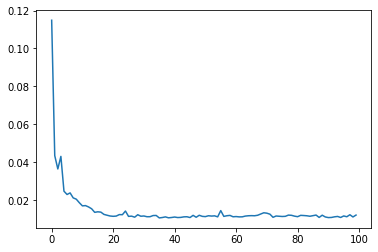

In [28]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=100
positive_correlation_stock_num=4
negative_correlation_sotck_num=4
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'data/temporal/sample',
    'data/temporal/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	

#training#
data1 :  (32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  12.415908370167017
evalution_cost :  2.8311807326972485
epoch : 0, t_cost : 0.193999, e_cost : 0.104859, elapsed time : 12.55sec
data1 :  (32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  3.6425337437540293
evalution_cost :  1.1617645807564259
epoch : 1, t_cost : 0.056915, e_cost : 0.043028, elapsed time : 9.48sec
data1 :  (32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  2.7046444453299046
evalution_cost :  0.7791476752609015
epoch : 2, t_cos

traning_cost :  0.6778432326391339
evalution_cost :  0.2753986696479842
epoch : 25, t_cost : 0.010591, e_cost : 0.010200, elapsed time : 9.36sec
data1 :  (32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.6823838846758008
evalution_cost :  0.2759426867123693
epoch : 26, t_cost : 0.010662, e_cost : 0.010220, elapsed time : 9.37sec
data1 :  (32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.7069972911849618
evalution_cost :  0.26847153052221984
epoch : 27, t_cost : 0.011047, e_cost : 0.009943, elapsed time : 9.36sec
data1 :  (32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.7132002227008343
evalution_cos

traning_cost :  0.6511182691901922
evalution_cost :  0.27482468995731324
epoch : 51, t_cost : 0.010174, e_cost : 0.010179, elapsed time : 9.37sec
data1 :  (32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.6448831907473505
evalution_cost :  0.27804848924279213
epoch : 52, t_cost : 0.010076, e_cost : 0.010298, elapsed time : 9.36sec
data1 :  (32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.6486257296055555
evalution_cost :  0.27460056403651834
epoch : 53, t_cost : 0.010135, e_cost : 0.010170, elapsed time : 9.37sec
data1 :  (32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.6320393574424088
evalution_c

traning_cost :  0.5313123589148745
evalution_cost :  0.2993384813889861
epoch : 77, t_cost : 0.008302, e_cost : 0.011087, elapsed time : 9.37sec
data1 :  (32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.5085679596522823
evalution_cost :  0.2992640455486253
epoch : 78, t_cost : 0.007946, e_cost : 0.011084, elapsed time : 9.36sec
data1 :  (32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.5411837338469923
evalution_cost :  0.2984928486403078
epoch : 79, t_cost : 0.008456, e_cost : 0.011055, elapsed time : 9.39sec
data1 :  (32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.5392079772427678
evalution_cost

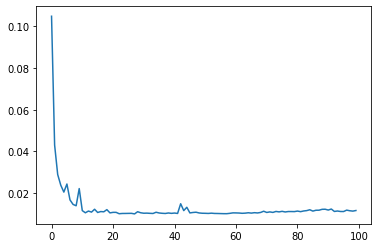

In [29]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=70
positive_correlation_stock_num=4
negative_correlation_sotck_num=4
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'data/temporal/sample',
    'data/temporal/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	

#training#
data1 :  (32479, 16, 1) (32479, 4, 16, 1) (32479, 4, 16, 1) (32479, 16, 1) (32479, 1)
data1 :  (13921, 16, 1) (13921, 4, 16, 1) (13921, 4, 16, 1) (13921, 16, 1) (13921, 1)
traning_cost :  11.711945578455925
evalution_cost :  1.6164692817255855
epoch : 0, t_cost : 0.185904, e_cost : 0.059869, elapsed time : 12.27sec
data1 :  (32479, 16, 1) (32479, 4, 16, 1) (32479, 4, 16, 1) (32479, 16, 1) (32479, 1)
data1 :  (13921, 16, 1) (13921, 4, 16, 1) (13921, 4, 16, 1) (13921, 16, 1) (13921, 1)
traning_cost :  3.7901273779571056
evalution_cost :  1.1397145665250719
epoch : 1, t_cost : 0.060161, e_cost : 0.042212, elapsed time : 9.27sec
data1 :  (32479, 16, 1) (32479, 4, 16, 1) (32479, 4, 16, 1) (32479, 16, 1) (32479, 1)
data1 :  (13921, 16, 1) (13921, 4, 16, 1) (13921, 4, 16, 1) (13921, 16, 1) (13921, 1)
traning_cost :  2.4846827145665884
evalution_cost :  0.8493860207963735
epoch : 2, t_cos

traning_cost :  0.7316442464943975
evalution_cost :  0.279217722825706
epoch : 25, t_cost : 0.011613, e_cost : 0.010341, elapsed time : 9.23sec
data1 :  (32479, 16, 1) (32479, 4, 16, 1) (32479, 4, 16, 1) (32479, 16, 1) (32479, 1)
data1 :  (13921, 16, 1) (13921, 4, 16, 1) (13921, 4, 16, 1) (13921, 16, 1) (13921, 1)
traning_cost :  0.7241969942115247
evalution_cost :  0.27477802452631295
epoch : 26, t_cost : 0.011495, e_cost : 0.010177, elapsed time : 9.25sec
data1 :  (32479, 16, 1) (32479, 4, 16, 1) (32479, 4, 16, 1) (32479, 16, 1) (32479, 1)
data1 :  (13921, 16, 1) (13921, 4, 16, 1) (13921, 4, 16, 1) (13921, 16, 1) (13921, 1)
traning_cost :  0.7095190424006432
evalution_cost :  0.2769136568531394
epoch : 27, t_cost : 0.011262, e_cost : 0.010256, elapsed time : 9.23sec
data1 :  (32479, 16, 1) (32479, 4, 16, 1) (32479, 4, 16, 1) (32479, 16, 1) (32479, 1)
data1 :  (13921, 16, 1) (13921, 4, 16, 1) (13921, 4, 16, 1) (13921, 16, 1) (13921, 1)
traning_cost :  0.7227432539220899
evalution_cost

traning_cost :  0.6534968127962202
evalution_cost :  0.2821462037973106
epoch : 51, t_cost : 0.010373, e_cost : 0.010450, elapsed time : 9.52sec
data1 :  (32479, 16, 1) (32479, 4, 16, 1) (32479, 4, 16, 1) (32479, 16, 1) (32479, 1)
data1 :  (13921, 16, 1) (13921, 4, 16, 1) (13921, 4, 16, 1) (13921, 16, 1) (13921, 1)
traning_cost :  0.6578247430734336
evalution_cost :  0.31487531401216984
epoch : 52, t_cost : 0.010442, e_cost : 0.011662, elapsed time : 9.29sec
data1 :  (32479, 16, 1) (32479, 4, 16, 1) (32479, 4, 16, 1) (32479, 16, 1) (32479, 1)
data1 :  (13921, 16, 1) (13921, 4, 16, 1) (13921, 4, 16, 1) (13921, 16, 1) (13921, 1)
traning_cost :  0.6442098983097821
evalution_cost :  0.2822028659284115
epoch : 53, t_cost : 0.010226, e_cost : 0.010452, elapsed time : 9.24sec
data1 :  (32479, 16, 1) (32479, 4, 16, 1) (32479, 4, 16, 1) (32479, 16, 1) (32479, 1)
data1 :  (13921, 16, 1) (13921, 4, 16, 1) (13921, 4, 16, 1) (13921, 16, 1) (13921, 1)
traning_cost :  0.6240211939439178
evalution_cos

traning_cost :  0.6221223550383002
evalution_cost :  0.2884022565558553
epoch : 77, t_cost : 0.009875, e_cost : 0.010682, elapsed time : 9.11sec
data1 :  (32479, 16, 1) (32479, 4, 16, 1) (32479, 4, 16, 1) (32479, 16, 1) (32479, 1)
data1 :  (13921, 16, 1) (13921, 4, 16, 1) (13921, 4, 16, 1) (13921, 16, 1) (13921, 1)
traning_cost :  0.5769178494811058
evalution_cost :  0.27954344311729074
epoch : 78, t_cost : 0.009157, e_cost : 0.010353, elapsed time : 9.14sec
data1 :  (32479, 16, 1) (32479, 4, 16, 1) (32479, 4, 16, 1) (32479, 16, 1) (32479, 1)
data1 :  (13921, 16, 1) (13921, 4, 16, 1) (13921, 4, 16, 1) (13921, 16, 1) (13921, 1)
traning_cost :  0.5702220124658197
evalution_cost :  0.2925174217671156
epoch : 79, t_cost : 0.009051, e_cost : 0.010834, elapsed time : 9.11sec
data1 :  (32479, 16, 1) (32479, 4, 16, 1) (32479, 4, 16, 1) (32479, 16, 1) (32479, 1)
data1 :  (13921, 16, 1) (13921, 4, 16, 1) (13921, 4, 16, 1) (13921, 16, 1) (13921, 1)
traning_cost :  0.5646502672461793
evalution_cos

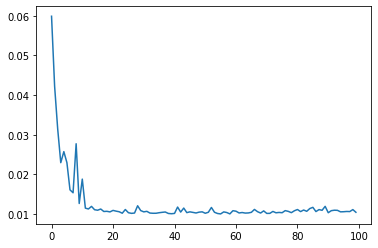

In [30]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=100
positive_correlation_stock_num=4
negative_correlation_sotck_num=4
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'data/temporal/sample',
    'data/temporal/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	

#training#
data1 :  (33040, 16, 1) (33040, 4, 16, 1) (33040, 4, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 4, 16, 1) (14160, 4, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  20.279638508800417
evalution_cost :  2.4737407718785107
epoch : 0, t_cost : 0.157207, e_cost : 0.044977, elapsed time : 13.44sec
data1 :  (33040, 16, 1) (33040, 4, 16, 1) (33040, 4, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 4, 16, 1) (14160, 4, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  5.87389011005871
evalution_cost :  1.648168671876192
epoch : 1, t_cost : 0.045534, e_cost : 0.029967, elapsed time : 10.23sec
data1 :  (33040, 16, 1) (33040, 4, 16, 1) (33040, 4, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 4, 16, 1) (14160, 4, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  3.9721500679152086
evalution_cost :  1.4830848830752075
epoch : 2, t_cost 

traning_cost :  1.3907708306214772
evalution_cost :  0.5865523053798825
epoch : 25, t_cost : 0.010781, e_cost : 0.010665, elapsed time : 10.16sec
data1 :  (33040, 16, 1) (33040, 4, 16, 1) (33040, 4, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 4, 16, 1) (14160, 4, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  1.3779680435545743
evalution_cost :  0.6039436559658498
epoch : 26, t_cost : 0.010682, e_cost : 0.010981, elapsed time : 10.15sec
data1 :  (33040, 16, 1) (33040, 4, 16, 1) (33040, 4, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 4, 16, 1) (14160, 4, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  1.3993235434172675
evalution_cost :  0.567871481878683
epoch : 27, t_cost : 0.010847, e_cost : 0.010325, elapsed time : 10.14sec
data1 :  (33040, 16, 1) (33040, 4, 16, 1) (33040, 4, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 4, 16, 1) (14160, 4, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  1.4023727258318104
evalution_co

traning_cost :  1.1808443584886845
evalution_cost :  0.5776116435881704
epoch : 51, t_cost : 0.009154, e_cost : 0.010502, elapsed time : 10.16sec
data1 :  (33040, 16, 1) (33040, 4, 16, 1) (33040, 4, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 4, 16, 1) (14160, 4, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  1.0703197160037234
evalution_cost :  0.5647274403600022
epoch : 52, t_cost : 0.008297, e_cost : 0.010268, elapsed time : 10.18sec
data1 :  (33040, 16, 1) (33040, 4, 16, 1) (33040, 4, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 4, 16, 1) (14160, 4, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  1.113784451619722
evalution_cost :  0.5641802528407425
epoch : 53, t_cost : 0.008634, e_cost : 0.010258, elapsed time : 10.51sec
data1 :  (33040, 16, 1) (33040, 4, 16, 1) (33040, 4, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 4, 16, 1) (14160, 4, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  1.0290581634035334
evalution_co

traning_cost :  0.9072064873762429
evalution_cost :  0.5527768016327173
epoch : 77, t_cost : 0.007033, e_cost : 0.010050, elapsed time : 10.14sec
data1 :  (33040, 16, 1) (33040, 4, 16, 1) (33040, 4, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 4, 16, 1) (14160, 4, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.7392417817027308
evalution_cost :  0.5776119985384867
epoch : 78, t_cost : 0.005731, e_cost : 0.010502, elapsed time : 10.16sec
data1 :  (33040, 16, 1) (33040, 4, 16, 1) (33040, 4, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 4, 16, 1) (14160, 4, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.7433717453386635
evalution_cost :  0.6061357608996332
epoch : 79, t_cost : 0.005763, e_cost : 0.011021, elapsed time : 10.16sec
data1 :  (33040, 16, 1) (33040, 4, 16, 1) (33040, 4, 16, 1) (33040, 16, 1) (33040, 1)
data1 :  (14160, 16, 1) (14160, 4, 16, 1) (14160, 4, 16, 1) (14160, 16, 1) (14160, 1)
traning_cost :  0.7428552499623038
evalution_c

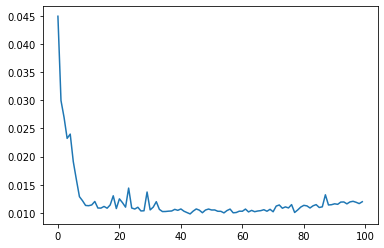

In [31]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=50
positive_correlation_stock_num=4
negative_correlation_sotck_num=4
train_test_rate=0.7
batch_size=256
#
kospi=StockData(
    'data/temporal/sample',
    'data/temporal/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	

#training#
data1 :  (32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  20.58417887846008
evalution_cost :  2.889115803875029
epoch : 0, t_cost : 0.160814, e_cost : 0.053502, elapsed time : 13.14sec
data1 :  (32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  5.710221910383552
evalution_cost :  1.5908426400274038
epoch : 1, t_cost : 0.044611, e_cost : 0.029460, elapsed time : 10.07sec
data1 :  (32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  3.8649738474632613
evalution_cost :  2.0432263668626547
epoch : 2, t_cost 

traning_cost :  1.371768968354445
evalution_cost :  0.5682851554593071
epoch : 25, t_cost : 0.010717, e_cost : 0.010524, elapsed time : 9.96sec
data1 :  (32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  1.5122815596987493
evalution_cost :  1.0007821801118553
epoch : 26, t_cost : 0.011815, e_cost : 0.018533, elapsed time : 9.98sec
data1 :  (32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  1.4796727480133995
evalution_cost :  0.5533229785505682
epoch : 27, t_cost : 0.011560, e_cost : 0.010247, elapsed time : 9.99sec
data1 :  (32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  1.3358276725921314
evalution_cost 

traning_cost :  1.1083978851238498
evalution_cost :  0.5744421196868643
epoch : 51, t_cost : 0.008659, e_cost : 0.010638, elapsed time : 10.07sec
data1 :  (32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  1.1927486490749288
evalution_cost :  0.5789081347174942
epoch : 52, t_cost : 0.009318, e_cost : 0.010721, elapsed time : 10.14sec
data1 :  (32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  1.2692116222460754
evalution_cost :  0.6199565874994732
epoch : 53, t_cost : 0.009916, e_cost : 0.011481, elapsed time : 10.07sec
data1 :  (32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  1.192788539454341
evalution_co

traning_cost :  0.7639065575203858
evalution_cost :  0.6273231169907376
epoch : 77, t_cost : 0.005968, e_cost : 0.011617, elapsed time : 10.14sec
data1 :  (32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.8112985101761296
evalution_cost :  0.663235672051087
epoch : 78, t_cost : 0.006338, e_cost : 0.012282, elapsed time : 10.09sec
data1 :  (32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.8841620871971827
evalution_cost :  0.609045545454137
epoch : 79, t_cost : 0.006908, e_cost : 0.011279, elapsed time : 10.06sec
data1 :  (32816, 16, 1) (32816, 4, 16, 1) (32816, 4, 16, 1) (32816, 16, 1) (32816, 1)
data1 :  (14064, 16, 1) (14064, 4, 16, 1) (14064, 4, 16, 1) (14064, 16, 1) (14064, 1)
traning_cost :  0.8089570478477981
evalution_cos

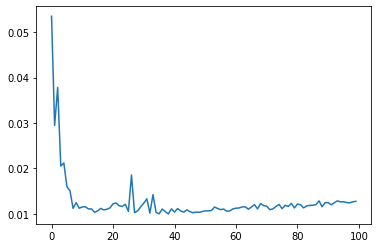

In [32]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=70
positive_correlation_stock_num=4
negative_correlation_sotck_num=4
train_test_rate=0.7
batch_size=256
#
kospi=StockData(
    'data/temporal/sample',
    'data/temporal/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	

#training#
data1 :  (32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  23.88138103391975
evalution_cost :  3.46992558427155
epoch : 0, t_cost : 0.186573, e_cost : 0.064258, elapsed time : 22.68sec
data1 :  (32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  6.934365707915276
evalution_cost :  2.619620628654957
epoch : 1, t_cost : 0.054175, e_cost : 0.048511, elapsed time : 19.77sec
data1 :  (32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  4.267334604985081
evalution_cost :  1.309421013807878
epoch : 2, t_cost : 0.

traning_cost :  1.3372157895355485
evalution_cost :  0.6009647323517129
epoch : 25, t_cost : 0.010447, e_cost : 0.011129, elapsed time : 19.95sec
data1 :  (32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  1.3924864273285493
evalution_cost :  0.6100817362312227
epoch : 26, t_cost : 0.010879, e_cost : 0.011298, elapsed time : 19.85sec
data1 :  (32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  1.3149106748751365
evalution_cost :  0.5700283044716343
epoch : 27, t_cost : 0.010273, e_cost : 0.010556, elapsed time : 19.80sec
data1 :  (32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  1.277953257667832
evalution_co

traning_cost :  1.0601066240342334
evalution_cost :  0.622921850765124
epoch : 51, t_cost : 0.008282, e_cost : 0.011536, elapsed time : 19.80sec
data1 :  (32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  1.0704192802659236
evalution_cost :  0.6414375848835334
epoch : 52, t_cost : 0.008363, e_cost : 0.011878, elapsed time : 19.87sec
data1 :  (32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  1.0167955734068528
evalution_cost :  0.5594989889068529
epoch : 53, t_cost : 0.007944, e_cost : 0.010361, elapsed time : 20.06sec
data1 :  (32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.9082173829374369
evalution_co

traning_cost :  0.6569277862436138
evalution_cost :  0.5828430701512843
epoch : 77, t_cost : 0.005132, e_cost : 0.010793, elapsed time : 19.79sec
data1 :  (32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.6564657572598662
evalution_cost :  0.5880037515889853
epoch : 78, t_cost : 0.005129, e_cost : 0.010889, elapsed time : 19.80sec
data1 :  (32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.6898605864262208
evalution_cost :  0.5948897083871998
epoch : 79, t_cost : 0.005390, e_cost : 0.011016, elapsed time : 19.80sec
data1 :  (32816, 32, 1) (32816, 4, 32, 1) (32816, 4, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 4, 32, 1) (14064, 4, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.6845269685727544
evalution_c

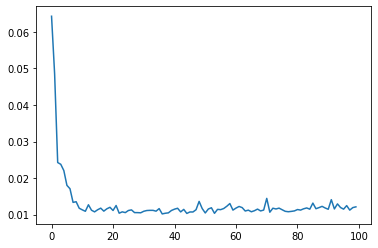

In [33]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=4
negative_correlation_sotck_num=4
train_test_rate=0.7
batch_size=256
#
kospi=StockData(
    'data/temporal/sample',
    'data/temporal/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	

#training#
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Flatten instead.
data1 :  (32816, 4, 1) (32816, 15, 4, 1) (32816, 15, 4, 1) (32816, 4, 1) (32

data1 :  (14064, 4, 1) (14064, 15, 4, 1) (14064, 15, 4, 1) (14064, 4, 1) (14064, 1)
traning_cost :  0.7746056180913001
evalution_cost :  0.3095285485032946
epoch : 17, t_cost : 0.012103, e_cost : 0.011464, elapsed time : 11.93sec
data1 :  (32816, 4, 1) (32816, 15, 4, 1) (32816, 15, 4, 1) (32816, 4, 1) (32816, 1)
data1 :  (14064, 4, 1) (14064, 15, 4, 1) (14064, 15, 4, 1) (14064, 4, 1) (14064, 1)
traning_cost :  0.7724253023043275
evalution_cost :  0.3040549837751314
epoch : 18, t_cost : 0.012069, e_cost : 0.011261, elapsed time : 11.84sec
data1 :  (32816, 4, 1) (32816, 15, 4, 1) (32816, 15, 4, 1) (32816, 4, 1) (32816, 1)
data1 :  (14064, 4, 1) (14064, 15, 4, 1) (14064, 15, 4, 1) (14064, 4, 1) (14064, 1)
traning_cost :  0.7699078302830458
evalution_cost :  0.29848191794008017
epoch : 19, t_cost : 0.012030, e_cost : 0.011055, elapsed time : 11.80sec
data1 :  (32816, 4, 1) (32816, 15, 4, 1) (32816, 15, 4, 1) (32816, 4, 1) (32816, 1)
data1 :  (14064, 4, 1) (14064, 15, 4, 1) (14064, 15, 4, 1

traning_cost :  0.7060256865806878
evalution_cost :  0.2855986407957971
epoch : 43, t_cost : 0.011032, e_cost : 0.010578, elapsed time : 11.98sec
data1 :  (32816, 4, 1) (32816, 15, 4, 1) (32816, 15, 4, 1) (32816, 4, 1) (32816, 1)
data1 :  (14064, 4, 1) (14064, 15, 4, 1) (14064, 15, 4, 1) (14064, 4, 1) (14064, 1)
traning_cost :  0.6977438724134117
evalution_cost :  0.283386985771358
epoch : 44, t_cost : 0.010902, e_cost : 0.010496, elapsed time : 11.77sec
data1 :  (32816, 4, 1) (32816, 15, 4, 1) (32816, 15, 4, 1) (32816, 4, 1) (32816, 1)
data1 :  (14064, 4, 1) (14064, 15, 4, 1) (14064, 15, 4, 1) (14064, 4, 1) (14064, 1)
traning_cost :  0.7019653900060803
evalution_cost :  0.2822031845571473
epoch : 45, t_cost : 0.010968, e_cost : 0.010452, elapsed time : 11.84sec
data1 :  (32816, 4, 1) (32816, 15, 4, 1) (32816, 15, 4, 1) (32816, 4, 1) (32816, 1)
data1 :  (14064, 4, 1) (14064, 15, 4, 1) (14064, 15, 4, 1) (14064, 4, 1) (14064, 1)
traning_cost :  0.7070807069540024
evalution_cost :  0.2863

data1 :  (14064, 4, 1) (14064, 15, 4, 1) (14064, 15, 4, 1) (14064, 4, 1) (14064, 1)
traning_cost :  0.6352320259902626
evalution_cost :  0.287646874319762
epoch : 70, t_cost : 0.009926, e_cost : 0.010654, elapsed time : 11.77sec
data1 :  (32816, 4, 1) (32816, 15, 4, 1) (32816, 15, 4, 1) (32816, 4, 1) (32816, 1)
data1 :  (14064, 4, 1) (14064, 15, 4, 1) (14064, 15, 4, 1) (14064, 4, 1) (14064, 1)
traning_cost :  0.6519726924598217
evalution_cost :  0.2882077044341713
epoch : 71, t_cost : 0.010187, e_cost : 0.010674, elapsed time : 11.75sec
data1 :  (32816, 4, 1) (32816, 15, 4, 1) (32816, 15, 4, 1) (32816, 4, 1) (32816, 1)
data1 :  (14064, 4, 1) (14064, 15, 4, 1) (14064, 15, 4, 1) (14064, 4, 1) (14064, 1)
traning_cost :  0.6400844282470644
evalution_cost :  0.2917889500968158
epoch : 72, t_cost : 0.010001, e_cost : 0.010807, elapsed time : 11.80sec
data1 :  (32816, 4, 1) (32816, 15, 4, 1) (32816, 15, 4, 1) (32816, 4, 1) (32816, 1)
data1 :  (14064, 4, 1) (14064, 15, 4, 1) (14064, 15, 4, 1) 

traning_cost :  0.5720811305800453
evalution_cost :  0.29750855825841427
epoch : 96, t_cost : 0.008939, e_cost : 0.011019, elapsed time : 11.95sec
data1 :  (32816, 4, 1) (32816, 15, 4, 1) (32816, 15, 4, 1) (32816, 4, 1) (32816, 1)
data1 :  (14064, 4, 1) (14064, 15, 4, 1) (14064, 15, 4, 1) (14064, 4, 1) (14064, 1)
traning_cost :  0.5756167958024889
evalution_cost :  0.2951904779765755
epoch : 97, t_cost : 0.008994, e_cost : 0.010933, elapsed time : 12.17sec
data1 :  (32816, 4, 1) (32816, 15, 4, 1) (32816, 15, 4, 1) (32816, 4, 1) (32816, 1)
data1 :  (14064, 4, 1) (14064, 15, 4, 1) (14064, 15, 4, 1) (14064, 4, 1) (14064, 1)
traning_cost :  0.5673451519105583
evalution_cost :  0.29255593568086624
epoch : 98, t_cost : 0.008865, e_cost : 0.010835, elapsed time : 11.92sec
data1 :  (32816, 4, 1) (32816, 15, 4, 1) (32816, 15, 4, 1) (32816, 4, 1) (32816, 1)
data1 :  (14064, 4, 1) (14064, 15, 4, 1) (14064, 15, 4, 1) (14064, 4, 1) (14064, 1)
traning_cost :  0.5586958636995405
evalution_cost :  0.2

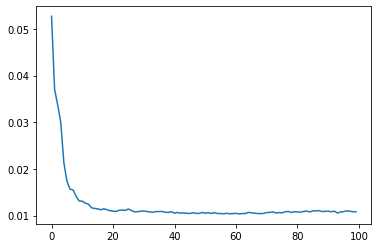

In [6]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=4
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'data/temporal/sample',
    'data/temporal/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (3000, 1)
StockPrice shape:  (3000, 16)
making dataset progress : finished	

#training#
data1 :  (32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  13.84275271743536
evalution_cost :  2.4345950819551945
epoch : 0, t_cost : 0.216293, e_cost : 0.090170, elapsed time : 93.23sec
data1 :  (32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  5.117510544136167
evalution_cost :  1.2896206323057413
epoch : 1, t_cost : 0.079961, e_cost : 0.047764, elapsed time : 83.37sec
data1 :  (32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  2.8727495800703764
evalution_cost :  0.9094525948166847
epoch

data1 :  (14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.7043683747760952
evalution_cost :  0.2870121164014563
epoch : 25, t_cost : 0.011006, e_cost : 0.010630, elapsed time : 82.45sec
data1 :  (32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.7453755682799965
evalution_cost :  0.2946409056894481
epoch : 26, t_cost : 0.011646, e_cost : 0.010913, elapsed time : 82.37sec
data1 :  (32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.7070572720840573
evalution_cost :  0.2915499219670892
epoch : 27, t_cost : 0.011048, e_cost : 0.010798, elapsed time : 82.63sec
data1 :  (32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 15

data1 :  (14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.6081050522625446
evalution_cost :  0.2930336680728942
epoch : 51, t_cost : 0.009502, e_cost : 0.010853, elapsed time : 47.60sec
data1 :  (32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.5963734893593937
evalution_cost :  0.2829802220221609
epoch : 52, t_cost : 0.009318, e_cost : 0.010481, elapsed time : 47.55sec
data1 :  (32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.5952056694077328
evalution_cost :  0.2861080535221845
epoch : 53, t_cost : 0.009300, e_cost : 0.010597, elapsed time : 47.83sec
data1 :  (32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 15

data1 :  (14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.49904654105193913
evalution_cost :  0.3073417670093477
epoch : 77, t_cost : 0.007798, e_cost : 0.011383, elapsed time : 81.21sec
data1 :  (32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.5218203227268532
evalution_cost :  0.353305654367432
epoch : 78, t_cost : 0.008153, e_cost : 0.013085, elapsed time : 81.40sec
data1 :  (32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 15, 32, 1) (14064, 15, 32, 1) (14064, 32, 1) (14064, 1)
traning_cost :  0.5489784583915025
evalution_cost :  0.318093067035079
epoch : 79, t_cost : 0.008578, e_cost : 0.011781, elapsed time : 79.01sec
data1 :  (32816, 32, 1) (32816, 15, 32, 1) (32816, 15, 32, 1) (32816, 32, 1) (32816, 1)
data1 :  (14064, 32, 1) (14064, 15,

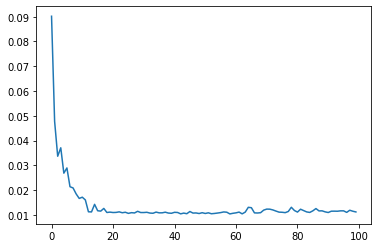

In [7]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'data/temporal/sample',
    'data/temporal/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

In [8]:
class StockData():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            indexPath : 종목시장의 인덱스 주 csv파일의 경로.
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈. 10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,indexPath,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize):        
               
        if(train_test_rate<=0 or train_test_rate>=1):
            raise ValueError('train_test_rate should be between 0 and 1')        
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath      
        self.indexPath=indexPath    
        self.batchSize=batchSize
        self.date_duration=4000
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))

        self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}
    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option is not 'training' and option is not 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')

        if(option is 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])             
        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,15,self.T,1))
        xn=np.reshape(xn,(-1,15,self.T,1))
        xi=np.reshape(xi,(-1,self.T,1))
        target=np.reshape(target,(-1,1))

        print("data1 : " , y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize],
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize],
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize],
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize],
                   'target':target[i*self.batchSize:(i+1)*self.batchSize]}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)        
        dataframe = pd.DataFrame([])
        

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python')
            if(len(data)>self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data['open']

                dataframe=dataframe.append(data,ignore_index=True)
        dataT=np.array(dataframe).T
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataT=dataT.T
        dataframe=pd.DataFrame(dataT)
        dataframe=dataframe.transpose()
        print('StockPrice shape: ',dataframe.shape)
        return dataframe
    
    def loadIndex(self):
        data=pd.read_csv(self.indexPath,engine='python')
        data=data[-self.date_duration-1:-1]        
        data=data.reset_index()
        data=data.fillna(method='ffill')

        data=np.array(data['Open'])
        data=np.reshape(data,(-1,1))

        data=self.indexScaler.fit_transform(data)

        data=pd.DataFrame(np.squeeze(data))        

        print('IndexPrice shape: ',data.shape)
        return data 


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in range(maxday,len(self.stockPrice)):
            print('making dataset progress : {}/{}'.format(i,len(self.stockPrice)),end='\r')
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexPrice.loc[i-self.T:i-1]

            for targetNum in priceSet.columns:
                target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[targetNum].T),(15,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[targetNum].T),(15,self.T,1))
                index_history=np.reshape(np.array(indexSet),(self.T,1))
                target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                            })
        print('making dataset progress : finished\t')
        
        return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            posSet.columns=range(self.P)
            negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

            
"""testLine
kospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)
print(np.shape(kospi.trainSet))
print(np.shape(kospi.testSet))
"""


"testLine\nkospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)\nprint(np.shape(kospi.trainSet))\nprint(np.shape(kospi.testSet))\n"

IndexPrice shape:  (4000, 1)
StockPrice shape:  (4000, 16)
making dataset progress : finished	

#training#
data1 :  (44016, 32, 1) (44016, 15, 32, 1) (44016, 15, 32, 1) (44016, 32, 1) (44016, 1)
data1 :  (18864, 32, 1) (18864, 15, 32, 1) (18864, 15, 32, 1) (18864, 32, 1) (18864, 1)
traning_cost :  14.767874728888273
evalution_cost :  2.1456494368612766
epoch : 0, t_cost : 0.173740, e_cost : 0.059601, elapsed time : 116.99sec
data1 :  (44016, 32, 1) (44016, 15, 32, 1) (44016, 15, 32, 1) (44016, 32, 1) (44016, 1)
data1 :  (18864, 32, 1) (18864, 15, 32, 1) (18864, 15, 32, 1) (18864, 32, 1) (18864, 1)
traning_cost :  3.6360739804804325
evalution_cost :  1.2990424111485481
epoch : 1, t_cost : 0.042777, e_cost : 0.036085, elapsed time : 107.19sec
data1 :  (44016, 32, 1) (44016, 15, 32, 1) (44016, 15, 32, 1) (44016, 32, 1) (44016, 1)
data1 :  (18864, 32, 1) (18864, 15, 32, 1) (18864, 15, 32, 1) (18864, 32, 1) (18864, 1)
traning_cost :  2.4617311507463455
evalution_cost :  0.9811027646064758
e

data1 :  (18864, 32, 1) (18864, 15, 32, 1) (18864, 15, 32, 1) (18864, 32, 1) (18864, 1)
traning_cost :  0.7727656641509384
evalution_cost :  0.33877627726178616
epoch : 25, t_cost : 0.009091, e_cost : 0.009410, elapsed time : 105.45sec
data1 :  (44016, 32, 1) (44016, 15, 32, 1) (44016, 15, 32, 1) (44016, 32, 1) (44016, 1)
data1 :  (18864, 32, 1) (18864, 15, 32, 1) (18864, 15, 32, 1) (18864, 32, 1) (18864, 1)
traning_cost :  0.82191984471865
evalution_cost :  0.3447504735086113
epoch : 26, t_cost : 0.009670, e_cost : 0.009576, elapsed time : 108.43sec
data1 :  (44016, 32, 1) (44016, 15, 32, 1) (44016, 15, 32, 1) (44016, 32, 1) (44016, 1)
data1 :  (18864, 32, 1) (18864, 15, 32, 1) (18864, 15, 32, 1) (18864, 32, 1) (18864, 1)
traning_cost :  0.7857185867615044
evalution_cost :  0.3333699080394581
epoch : 27, t_cost : 0.009244, e_cost : 0.009260, elapsed time : 109.31sec
data1 :  (44016, 32, 1) (44016, 15, 32, 1) (44016, 15, 32, 1) (44016, 32, 1) (44016, 1)
data1 :  (18864, 32, 1) (18864, 

data1 :  (44016, 32, 1) (44016, 15, 32, 1) (44016, 15, 32, 1) (44016, 32, 1) (44016, 1)
data1 :  (18864, 32, 1) (18864, 15, 32, 1) (18864, 15, 32, 1) (18864, 32, 1) (18864, 1)
traning_cost :  0.6423133399803191
evalution_cost :  0.35816611163318157
epoch : 51, t_cost : 0.007557, e_cost : 0.009949, elapsed time : 106.82sec
data1 :  (44016, 32, 1) (44016, 15, 32, 1) (44016, 15, 32, 1) (44016, 32, 1) (44016, 1)
data1 :  (18864, 32, 1) (18864, 15, 32, 1) (18864, 15, 32, 1) (18864, 32, 1) (18864, 1)
traning_cost :  0.6679611871950328
evalution_cost :  0.3704760135151446
epoch : 52, t_cost : 0.007858, e_cost : 0.010291, elapsed time : 108.60sec
data1 :  (44016, 32, 1) (44016, 15, 32, 1) (44016, 15, 32, 1) (44016, 32, 1) (44016, 1)
data1 :  (18864, 32, 1) (18864, 15, 32, 1) (18864, 15, 32, 1) (18864, 32, 1) (18864, 1)
traning_cost :  0.6246479033725336
evalution_cost :  0.3416147307725623
epoch : 53, t_cost : 0.007349, e_cost : 0.009489, elapsed time : 110.55sec
data1 :  (44016, 32, 1) (44016

traning_cost :  0.5374502488411963
evalution_cost :  0.373155714944005
epoch : 76, t_cost : 0.006323, e_cost : 0.010365, elapsed time : 71.18sec
data1 :  (44016, 32, 1) (44016, 15, 32, 1) (44016, 15, 32, 1) (44016, 32, 1) (44016, 1)
data1 :  (18864, 32, 1) (18864, 15, 32, 1) (18864, 15, 32, 1) (18864, 32, 1) (18864, 1)
traning_cost :  0.5249492882285267
evalution_cost :  0.3657504670554772
epoch : 77, t_cost : 0.006176, e_cost : 0.010160, elapsed time : 104.65sec
data1 :  (44016, 32, 1) (44016, 15, 32, 1) (44016, 15, 32, 1) (44016, 32, 1) (44016, 1)
data1 :  (18864, 32, 1) (18864, 15, 32, 1) (18864, 15, 32, 1) (18864, 32, 1) (18864, 1)
traning_cost :  0.5745360921137035
evalution_cost :  0.416094513842836
epoch : 78, t_cost : 0.006759, e_cost : 0.011558, elapsed time : 102.31sec
data1 :  (44016, 32, 1) (44016, 15, 32, 1) (44016, 15, 32, 1) (44016, 32, 1) (44016, 1)
data1 :  (18864, 32, 1) (18864, 15, 32, 1) (18864, 15, 32, 1) (18864, 32, 1) (18864, 1)
traning_cost :  0.5863628091756254

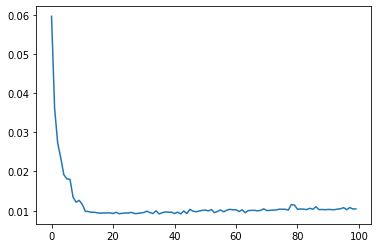

In [9]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'data/temporal/sample',
    'data/temporal/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (4000, 1)
StockPrice shape:  (4000, 16)
making dataset progress : finished	

#training#
data1 :  (44016, 16, 1) (44016, 15, 16, 1) (44016, 15, 16, 1) (44016, 16, 1) (44016, 1)
data1 :  (18864, 16, 1) (18864, 15, 16, 1) (18864, 15, 16, 1) (18864, 16, 1) (18864, 1)
traning_cost :  16.26554710417986
evalution_cost :  2.6415201034396887
epoch : 0, t_cost : 0.191359, e_cost : 0.073376, elapsed time : 66.89sec
data1 :  (44016, 16, 1) (44016, 15, 16, 1) (44016, 15, 16, 1) (44016, 16, 1) (44016, 1)
data1 :  (18864, 16, 1) (18864, 15, 16, 1) (18864, 15, 16, 1) (18864, 16, 1) (18864, 1)
traning_cost :  4.6781198009848595
evalution_cost :  1.8074373230338097
epoch : 1, t_cost : 0.055037, e_cost : 0.050207, elapsed time : 53.65sec
data1 :  (44016, 16, 1) (44016, 15, 16, 1) (44016, 15, 16, 1) (44016, 16, 1) (44016, 1)
data1 :  (18864, 16, 1) (18864, 15, 16, 1) (18864, 15, 16, 1) (18864, 16, 1) (18864, 1)
traning_cost :  3.1282376563176513
evalution_cost :  0.9863935504108667
epoc

data1 :  (18864, 16, 1) (18864, 15, 16, 1) (18864, 15, 16, 1) (18864, 16, 1) (18864, 1)
traning_cost :  0.885963722364977
evalution_cost :  0.39226142317056656
epoch : 25, t_cost : 0.010423, e_cost : 0.010896, elapsed time : 54.92sec
data1 :  (44016, 16, 1) (44016, 15, 16, 1) (44016, 15, 16, 1) (44016, 16, 1) (44016, 1)
data1 :  (18864, 16, 1) (18864, 15, 16, 1) (18864, 15, 16, 1) (18864, 16, 1) (18864, 1)
traning_cost :  0.8546058156061918
evalution_cost :  0.35212266142480075
epoch : 26, t_cost : 0.010054, e_cost : 0.009781, elapsed time : 55.30sec
data1 :  (44016, 16, 1) (44016, 15, 16, 1) (44016, 15, 16, 1) (44016, 16, 1) (44016, 1)
data1 :  (18864, 16, 1) (18864, 15, 16, 1) (18864, 15, 16, 1) (18864, 16, 1) (18864, 1)
traning_cost :  0.8396295672282577
evalution_cost :  0.3477596892043948
epoch : 27, t_cost : 0.009878, e_cost : 0.009660, elapsed time : 53.42sec
data1 :  (44016, 16, 1) (44016, 15, 16, 1) (44016, 15, 16, 1) (44016, 16, 1) (44016, 1)
data1 :  (18864, 16, 1) (18864, 1

data1 :  (18864, 16, 1) (18864, 15, 16, 1) (18864, 15, 16, 1) (18864, 16, 1) (18864, 1)
traning_cost :  0.7372373149264604
evalution_cost :  0.3670785261783749
epoch : 51, t_cost : 0.008673, e_cost : 0.010197, elapsed time : 27.53sec
data1 :  (44016, 16, 1) (44016, 15, 16, 1) (44016, 15, 16, 1) (44016, 16, 1) (44016, 1)
data1 :  (18864, 16, 1) (18864, 15, 16, 1) (18864, 15, 16, 1) (18864, 16, 1) (18864, 1)
traning_cost :  0.7195745846256614
evalution_cost :  0.36541576590389013
epoch : 52, t_cost : 0.008466, e_cost : 0.010150, elapsed time : 27.55sec
data1 :  (44016, 16, 1) (44016, 15, 16, 1) (44016, 15, 16, 1) (44016, 16, 1) (44016, 1)
data1 :  (18864, 16, 1) (18864, 15, 16, 1) (18864, 15, 16, 1) (18864, 16, 1) (18864, 1)
traning_cost :  0.7106876098550856
evalution_cost :  0.36910932091996074
epoch : 53, t_cost : 0.008361, e_cost : 0.010253, elapsed time : 27.73sec
data1 :  (44016, 16, 1) (44016, 15, 16, 1) (44016, 15, 16, 1) (44016, 16, 1) (44016, 1)
data1 :  (18864, 16, 1) (18864, 

data1 :  (18864, 16, 1) (18864, 15, 16, 1) (18864, 15, 16, 1) (18864, 16, 1) (18864, 1)
traning_cost :  0.6189501414773986
evalution_cost :  0.3995393831282854
epoch : 77, t_cost : 0.007282, e_cost : 0.011098, elapsed time : 28.02sec
data1 :  (44016, 16, 1) (44016, 15, 16, 1) (44016, 15, 16, 1) (44016, 16, 1) (44016, 1)
data1 :  (18864, 16, 1) (18864, 15, 16, 1) (18864, 15, 16, 1) (18864, 16, 1) (18864, 1)
traning_cost :  0.5915338442428038
evalution_cost :  0.4144814710598439
epoch : 78, t_cost : 0.006959, e_cost : 0.011513, elapsed time : 28.31sec
data1 :  (44016, 16, 1) (44016, 15, 16, 1) (44016, 15, 16, 1) (44016, 16, 1) (44016, 1)
data1 :  (18864, 16, 1) (18864, 15, 16, 1) (18864, 15, 16, 1) (18864, 16, 1) (18864, 1)
traning_cost :  0.5755365375662223
evalution_cost :  0.38978211826179177
epoch : 79, t_cost : 0.006771, e_cost : 0.010827, elapsed time : 27.80sec
data1 :  (44016, 16, 1) (44016, 15, 16, 1) (44016, 15, 16, 1) (44016, 16, 1) (44016, 1)
data1 :  (18864, 16, 1) (18864, 1

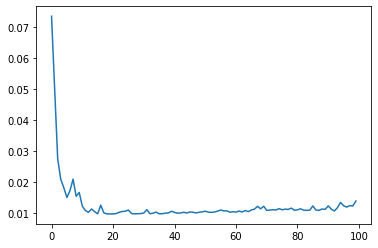

In [10]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'data/temporal/sample',
    'data/temporal/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (4000, 1)
StockPrice shape:  (4000, 16)
making dataset progress : finished	

#training#
data1 :  (50304, 32, 1) (50304, 15, 32, 1) (50304, 15, 32, 1) (50304, 32, 1) (50304, 1)
data1 :  (12576, 32, 1) (12576, 15, 32, 1) (12576, 15, 32, 1) (12576, 32, 1) (12576, 1)
traning_cost :  16.469315722584724
evalution_cost :  1.9656792916357517
epoch : 0, t_cost : 0.168054, e_cost : 0.081903, elapsed time : 67.81sec
data1 :  (50304, 32, 1) (50304, 15, 32, 1) (50304, 15, 32, 1) (50304, 32, 1) (50304, 1)
data1 :  (12576, 32, 1) (12576, 15, 32, 1) (12576, 15, 32, 1) (12576, 32, 1) (12576, 1)
traning_cost :  4.009231003001332
evalution_cost :  0.8403397062793374
epoch : 1, t_cost : 0.040911, e_cost : 0.035014, elapsed time : 60.42sec
data1 :  (50304, 32, 1) (50304, 15, 32, 1) (50304, 15, 32, 1) (50304, 32, 1) (50304, 1)
data1 :  (12576, 32, 1) (12576, 15, 32, 1) (12576, 15, 32, 1) (12576, 32, 1) (12576, 1)
traning_cost :  2.801055054180324
evalution_cost :  0.578478398732841
epoch 

data1 :  (12576, 32, 1) (12576, 15, 32, 1) (12576, 15, 32, 1) (12576, 32, 1) (12576, 1)
traning_cost :  0.8261022608494386
evalution_cost :  0.31702686753124
epoch : 25, t_cost : 0.008430, e_cost : 0.013209, elapsed time : 119.61sec
data1 :  (50304, 32, 1) (50304, 15, 32, 1) (50304, 15, 32, 1) (50304, 32, 1) (50304, 1)
data1 :  (12576, 32, 1) (12576, 15, 32, 1) (12576, 15, 32, 1) (12576, 32, 1) (12576, 1)
traning_cost :  0.8677561117801815
evalution_cost :  0.25410413974896073
epoch : 26, t_cost : 0.008855, e_cost : 0.010588, elapsed time : 117.51sec
data1 :  (50304, 32, 1) (50304, 15, 32, 1) (50304, 15, 32, 1) (50304, 32, 1) (50304, 1)
data1 :  (12576, 32, 1) (12576, 15, 32, 1) (12576, 15, 32, 1) (12576, 32, 1) (12576, 1)
traning_cost :  0.8529256149195135
evalution_cost :  0.2548240046016872
epoch : 27, t_cost : 0.008703, e_cost : 0.010618, elapsed time : 115.06sec
data1 :  (50304, 32, 1) (50304, 15, 32, 1) (50304, 15, 32, 1) (50304, 32, 1) (50304, 1)
data1 :  (12576, 32, 1) (12576, 

data1 :  (50304, 32, 1) (50304, 15, 32, 1) (50304, 15, 32, 1) (50304, 32, 1) (50304, 1)
data1 :  (12576, 32, 1) (12576, 15, 32, 1) (12576, 15, 32, 1) (12576, 32, 1) (12576, 1)
traning_cost :  0.7025145711377263
evalution_cost :  0.25221919117029756
epoch : 51, t_cost : 0.007169, e_cost : 0.010509, elapsed time : 124.20sec
data1 :  (50304, 32, 1) (50304, 15, 32, 1) (50304, 15, 32, 1) (50304, 32, 1) (50304, 1)
data1 :  (12576, 32, 1) (12576, 15, 32, 1) (12576, 15, 32, 1) (12576, 32, 1) (12576, 1)
traning_cost :  0.7401409543817863
evalution_cost :  0.25008693884592503
epoch : 52, t_cost : 0.007552, e_cost : 0.010420, elapsed time : 81.63sec
data1 :  (50304, 32, 1) (50304, 15, 32, 1) (50304, 15, 32, 1) (50304, 32, 1) (50304, 1)
data1 :  (12576, 32, 1) (12576, 15, 32, 1) (12576, 15, 32, 1) (12576, 32, 1) (12576, 1)
traning_cost :  0.708351117791608
evalution_cost :  0.25362359569408
epoch : 53, t_cost : 0.007228, e_cost : 0.010568, elapsed time : 74.29sec
data1 :  (50304, 32, 1) (50304, 15

traning_cost :  0.7910559888696298
evalution_cost :  0.2932767414022237
epoch : 76, t_cost : 0.008072, e_cost : 0.012220, elapsed time : 127.73sec
data1 :  (50304, 32, 1) (50304, 15, 32, 1) (50304, 15, 32, 1) (50304, 32, 1) (50304, 1)
data1 :  (12576, 32, 1) (12576, 15, 32, 1) (12576, 15, 32, 1) (12576, 32, 1) (12576, 1)
traning_cost :  0.6062498077517375
evalution_cost :  0.28045941423624754
epoch : 77, t_cost : 0.006186, e_cost : 0.011686, elapsed time : 127.29sec
data1 :  (50304, 32, 1) (50304, 15, 32, 1) (50304, 15, 32, 1) (50304, 32, 1) (50304, 1)
data1 :  (12576, 32, 1) (12576, 15, 32, 1) (12576, 15, 32, 1) (12576, 32, 1) (12576, 1)
traning_cost :  0.5913829721976072
evalution_cost :  0.27714699134230614
epoch : 78, t_cost : 0.006035, e_cost : 0.011548, elapsed time : 127.63sec
data1 :  (50304, 32, 1) (50304, 15, 32, 1) (50304, 15, 32, 1) (50304, 32, 1) (50304, 1)
data1 :  (12576, 32, 1) (12576, 15, 32, 1) (12576, 15, 32, 1) (12576, 32, 1) (12576, 1)
traning_cost :  0.58763155515

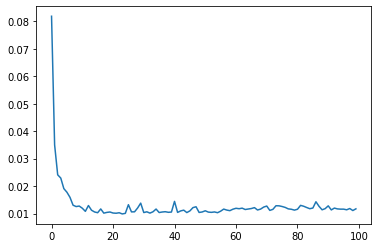

In [11]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=32
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.8
batch_size=512
#
kospi=StockData(
    'data/temporal/sample',
    'data/temporal/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))

IndexPrice shape:  (4000, 1)
StockPrice shape:  (4000, 16)
making dataset progress : finished	

#training#
data1 :  (50304, 16, 1) (50304, 15, 16, 1) (50304, 15, 16, 1) (50304, 16, 1) (50304, 1)
data1 :  (12576, 16, 1) (12576, 15, 16, 1) (12576, 15, 16, 1) (12576, 16, 1) (12576, 1)
traning_cost :  15.63517091423273
evalution_cost :  1.1849270947277546
epoch : 0, t_cost : 0.159543, e_cost : 0.049372, elapsed time : 78.52sec
data1 :  (50304, 16, 1) (50304, 15, 16, 1) (50304, 15, 16, 1) (50304, 16, 1) (50304, 1)
data1 :  (12576, 16, 1) (12576, 15, 16, 1) (12576, 15, 16, 1) (12576, 16, 1) (12576, 1)
traning_cost :  4.318831488490105
evalution_cost :  0.9068787740543485
epoch : 1, t_cost : 0.044070, e_cost : 0.037787, elapsed time : 65.32sec
data1 :  (50304, 16, 1) (50304, 15, 16, 1) (50304, 15, 16, 1) (50304, 16, 1) (50304, 1)
data1 :  (12576, 16, 1) (12576, 15, 16, 1) (12576, 15, 16, 1) (12576, 16, 1) (12576, 1)
traning_cost :  2.849170256406069
evalution_cost :  0.7586629064753652
epoch 

data1 :  (12576, 16, 1) (12576, 15, 16, 1) (12576, 15, 16, 1) (12576, 16, 1) (12576, 1)
traning_cost :  0.9206472898367792
evalution_cost :  0.24459884606767446
epoch : 25, t_cost : 0.009394, e_cost : 0.010192, elapsed time : 62.31sec
data1 :  (50304, 16, 1) (50304, 15, 16, 1) (50304, 15, 16, 1) (50304, 16, 1) (50304, 1)
data1 :  (12576, 16, 1) (12576, 15, 16, 1) (12576, 15, 16, 1) (12576, 16, 1) (12576, 1)
traning_cost :  0.9065394229255617
evalution_cost :  0.2606873596087098
epoch : 26, t_cost : 0.009250, e_cost : 0.010862, elapsed time : 61.94sec
data1 :  (50304, 16, 1) (50304, 15, 16, 1) (50304, 15, 16, 1) (50304, 16, 1) (50304, 1)
data1 :  (12576, 16, 1) (12576, 15, 16, 1) (12576, 15, 16, 1) (12576, 16, 1) (12576, 1)
traning_cost :  0.9244629507884383
evalution_cost :  0.2637267305981368
epoch : 27, t_cost : 0.009433, e_cost : 0.010989, elapsed time : 61.90sec
data1 :  (50304, 16, 1) (50304, 15, 16, 1) (50304, 15, 16, 1) (50304, 16, 1) (50304, 1)
data1 :  (12576, 16, 1) (12576, 1

data1 :  (12576, 16, 1) (12576, 15, 16, 1) (12576, 15, 16, 1) (12576, 16, 1) (12576, 1)
traning_cost :  0.8362493922468275
evalution_cost :  0.2497680983506143
epoch : 51, t_cost : 0.008533, e_cost : 0.010407, elapsed time : 29.99sec
data1 :  (50304, 16, 1) (50304, 15, 16, 1) (50304, 15, 16, 1) (50304, 16, 1) (50304, 1)
data1 :  (12576, 16, 1) (12576, 15, 16, 1) (12576, 15, 16, 1) (12576, 16, 1) (12576, 1)
traning_cost :  0.7992387448903173
evalution_cost :  0.24432473978959024
epoch : 52, t_cost : 0.008155, e_cost : 0.010180, elapsed time : 29.97sec
data1 :  (50304, 16, 1) (50304, 15, 16, 1) (50304, 15, 16, 1) (50304, 16, 1) (50304, 1)
data1 :  (12576, 16, 1) (12576, 15, 16, 1) (12576, 15, 16, 1) (12576, 16, 1) (12576, 1)
traning_cost :  0.8023652664851397
evalution_cost :  0.24369443324394524
epoch : 53, t_cost : 0.008187, e_cost : 0.010154, elapsed time : 29.97sec
data1 :  (50304, 16, 1) (50304, 15, 16, 1) (50304, 15, 16, 1) (50304, 16, 1) (50304, 1)
data1 :  (12576, 16, 1) (12576, 

data1 :  (12576, 16, 1) (12576, 15, 16, 1) (12576, 15, 16, 1) (12576, 16, 1) (12576, 1)
traning_cost :  0.6580850994214416
evalution_cost :  0.248108432861045
epoch : 77, t_cost : 0.006715, e_cost : 0.010338, elapsed time : 29.98sec
data1 :  (50304, 16, 1) (50304, 15, 16, 1) (50304, 15, 16, 1) (50304, 16, 1) (50304, 1)
data1 :  (12576, 16, 1) (12576, 15, 16, 1) (12576, 15, 16, 1) (12576, 16, 1) (12576, 1)
traning_cost :  0.6759425558848307
evalution_cost :  0.2584870201535523
epoch : 78, t_cost : 0.006897, e_cost : 0.010770, elapsed time : 30.00sec
data1 :  (50304, 16, 1) (50304, 15, 16, 1) (50304, 15, 16, 1) (50304, 16, 1) (50304, 1)
data1 :  (12576, 16, 1) (12576, 15, 16, 1) (12576, 15, 16, 1) (12576, 16, 1) (12576, 1)
traning_cost :  0.6885795468697324
evalution_cost :  0.24732278240844607
epoch : 79, t_cost : 0.007026, e_cost : 0.010305, elapsed time : 29.93sec
data1 :  (50304, 16, 1) (50304, 15, 16, 1) (50304, 15, 16, 1) (50304, 16, 1) (50304, 1)
data1 :  (12576, 16, 1) (12576, 15

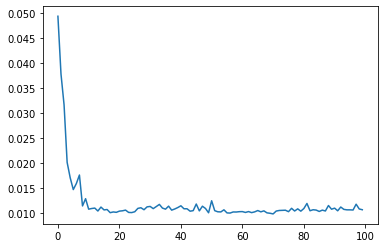

In [12]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.8
batch_size=512
#
kospi=StockData(
    'data/temporal/sample',
    'data/temporal/Temperature_Comedor_Sensor.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))